> # Importations des Librairies

In [1]:
#importer pandas as pd, numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn import metrics
import joblib

> # Collection des Données et Traitement

In [2]:
#importer le dataset car_price_prediction.csv avec pandas

df = pd.read_csv('/Users/MAC/Downloads/car_price_prediction.csv')
df.head()



,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [3]:
# Afficher les informations du dataset
print(df.shape)  
print(df.info())


(19237, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-

> * ***Levy et Mileage sont des chaînes de caractères au lieu d'êtres des valeurs numériques.***
> 
> * ***Doors  a un formatage incohérent (e.g., "04-May").***
> 
> * ***Engine volume  contient des indications de turbo.***
> * ***Levy a '-' qui represente les valeurs manquantes.***

> # NETTOYAGE DES DONNÉES

In [4]:
# Recodage de Levy et evaluation de son asymétrie autour de la moyenne
df['Levy'] = df['Levy'].replace('-', np.nan).astype(float)
df['Engine volume'] = pd.to_numeric(df['Engine volume'].str.replace(' Turbo',''), errors='coerce')
df['Mileage'] = pd.to_numeric(df['Mileage'].str.replace(' km',''), errors='coerce')
doors_map = {'02-Mar':2, '04-May':4, '>5':6}
df['Doors'] = df['Doors'].map(doors_map).astype(int)

# Recodage de 'leather interior' et 'wheel'
df['Leather interior'] = df['Leather interior'].map({'Yes':1,'No':0})
df['Wheel'] = df['Wheel'].apply(lambda x: 1 if 'Right' in x else 0)

# Supprimer les colonnes inutiles
df = df.drop(['ID'], axis=1)

# Afficher les informations du dataset après le nettoyage
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             19237 non-null  int64  
 1   Levy              13418 non-null  float64
 2   Manufacturer      19237 non-null  object 
 3   Model             19237 non-null  object 
 4   Prod. year        19237 non-null  int64  
 5   Category          19237 non-null  object 
 6   Leather interior  19237 non-null  int64  
 7   Fuel type         19237 non-null  object 
 8   Engine volume     19237 non-null  float64
 9   Mileage           19237 non-null  int64  
 10  Cylinders         19237 non-null  float64
 11  Gear box type     19237 non-null  object 
 12  Drive wheels      19237 non-null  object 
 13  Doors             19237 non-null  int64  
 14  Wheel             19237 non-null  int64  
 15  Color             19237 non-null  object 
 16  Airbags           19237 non-null  int64 

In [5]:
# Afficher les valeurs manquantes
print(df.isnull().sum())


Price                  0
Levy                5819
Manufacturer           0
Model                  0
Prod. year             0
Category               0
Leather interior       0
Fuel type              0
Engine volume          0
Mileage                0
Cylinders              0
Gear box type          0
Drive wheels           0
Doors                  0
Wheel                  0
Color                  0
Airbags                0
dtype: int64


In [6]:
duplicates = df[df.duplicated(keep=False)]  

# Afficher les lignes dupliquées
if duplicates.empty:
    print("No duplicate rows found.")
else:
    print(f"Found {len(duplicates)} duplicate rows:")
    print(duplicates.sort_values(by=duplicates.columns.tolist()).head())

# Compter les doublons et afficher le nombre de fois que chaque doublon apparaît
duplicate_counts = duplicates.groupby(df.columns.tolist()).size().reset_index(name='Count')
print("\nDuplicate counts:")
print(duplicate_counts)

# Supprimer les doublons
df.drop_duplicates(inplace=True)




Found 4927 duplicate rows:
      Price  Levy Manufacturer Model  Prod. year   Category  Leather interior  \
214      30   NaN        HONDA   FIT        2002  Hatchback                 0   
7466     30   NaN        HONDA   FIT        2002  Hatchback                 0   
2285     30   NaN        HONDA   FIT        2003  Hatchback                 0   
2747     30   NaN        HONDA   FIT        2003  Hatchback                 0   
6813     30   NaN        HONDA   FIT        2003  Hatchback                 0   

     Fuel type  Engine volume  Mileage  Cylinders Gear box type Drive wheels  \
214     Petrol            1.5        0        4.0     Automatic        Front   
7466    Petrol            1.5        0        4.0     Automatic        Front   
2285    Petrol            1.3        0        4.0     Automatic        Front   
2747    Petrol            1.3        0        4.0     Automatic        Front   
6813    Petrol            1.3        0        4.0     Automatic        Front   

     

In [7]:
# Verifier à nouveau les doublons après suppression
duplicates = df[df.duplicated(keep=False)]
if duplicates.empty:
    print("No duplicate rows found.")
else:
    print(f"Found {len(duplicates)} duplicate rows:")
    print(duplicates.sort_values(by=duplicates.columns.tolist()).head())

# Compter les doublons et afficher le nombre de fois que chaque doublon apparaît
duplicate_counts = duplicates.groupby(df.columns.tolist()).size().reset_index(name='Count')
print("\nDuplicate counts:")
print(duplicate_counts)


No duplicate rows found.

Duplicate counts:
Empty DataFrame
Columns: [Price, Levy, Manufacturer, Model, Prod. year, Category, Leather interior, Fuel type, Engine volume, Mileage, Cylinders, Gear box type, Drive wheels, Doors, Wheel, Color, Airbags, Count]
Index: []


In [8]:
# Afficher les informations du dataset après le nettoyage
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 15725 entries, 0 to 19236
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             15725 non-null  int64  
 1   Levy              10041 non-null  float64
 2   Manufacturer      15725 non-null  object 
 3   Model             15725 non-null  object 
 4   Prod. year        15725 non-null  int64  
 5   Category          15725 non-null  object 
 6   Leather interior  15725 non-null  int64  
 7   Fuel type         15725 non-null  object 
 8   Engine volume     15725 non-null  float64
 9   Mileage           15725 non-null  int64  
 10  Cylinders         15725 non-null  float64
 11  Gear box type     15725 non-null  object 
 12  Drive wheels      15725 non-null  object 
 13  Doors             15725 non-null  int64  
 14  Wheel             15725 non-null  int64  
 15  Color             15725 non-null  object 
 16  Airbags           15725 non-null  int64  
dty

In [9]:
# Afficher les valeurs manquantes
print(df.isnull().sum())


Price                  0
Levy                5684
Manufacturer           0
Model                  0
Prod. year             0
Category               0
Leather interior       0
Fuel type              0
Engine volume          0
Mileage                0
Cylinders              0
Gear box type          0
Drive wheels           0
Doors                  0
Wheel                  0
Color                  0
Airbags                0
dtype: int64


In [10]:
# Évaluation de son asymétrie autour de la moyenne
print(f"Skewness: {df['Levy'].skew():.2f}")  
print(f"Mean: {df['Levy'].mean():.2f}, Median: {df['Levy'].median():.2f}")
print(f"Max: {df['Levy'].max()}, Min: {df['Levy'].min()}")
# Asymétrie de la variable 'Price'
print(f"Skewness: {df['Price'].skew():.2f}") 
print(f"Mean: {df['Price'].mean():.2f}, Median: {df['Price'].median():.2f}")
print(f"Max: {df['Price'].max()}, Min: {df['Price'].min()}") 

Skewness: 7.03
Mean: 879.44, Median: 779.00
Max: 11714.0, Min: 87.0
Skewness: 123.63
Mean: 20279.44, Median: 14166.00
Max: 26307500, Min: 1


> * ***Skewness > 1, on a donc une distribution à forte asymétrique à droite, la majorité des véhicule on une taxe Levy modérée mais une petite partie des véhicules a une taxe Levy très élevée, ce qui provoque une surévaluation de la moyenne. Dans ce cas, la moyenne ne représente pas la valeur typique de la taxe Levy. on peut donc utiliser la médiane pour obtenir une valeur plus représentative de la taxe Levy.***

In [11]:
# Imputer la médiane des valeurs manquantes de Levy
df['Levy'] = df['Levy'].fillna(df['Levy'].median())

# Afficher les valeurs manquantes
print(df.isnull().sum())


Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64


              Price          Levy    Prod. year  Leather interior  \
count  1.572500e+04  15725.000000  15725.000000      15725.000000   
mean   2.027944e+04    843.134817   2010.518919          0.671415   
std    2.106390e+05    369.754477      6.012122          0.469714   
min    1.000000e+00     87.000000   1939.000000          0.000000   
25%    7.527000e+03    746.000000   2008.000000          0.000000   
50%    1.416600e+04    779.000000   2012.000000          1.000000   
75%    2.336400e+04    862.000000   2014.000000          1.000000   
max    2.630750e+07  11714.000000   2020.000000          1.000000   

       Engine volume       Mileage     Cylinders         Doors         Wheel  \
count   15725.000000  1.572500e+04  15725.000000  15725.000000  15725.000000   
mean        2.212820  1.836421e+06      4.483561      3.920890      0.091065   
std         0.806187  5.353248e+07      1.134466      0.463745      0.287711   
min         0.000000  0.000000e+00      1.000000      2.00

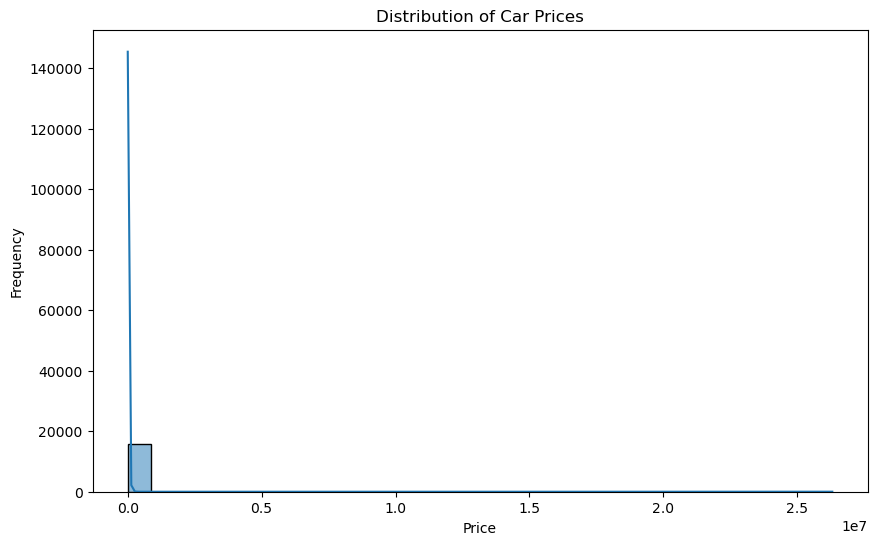

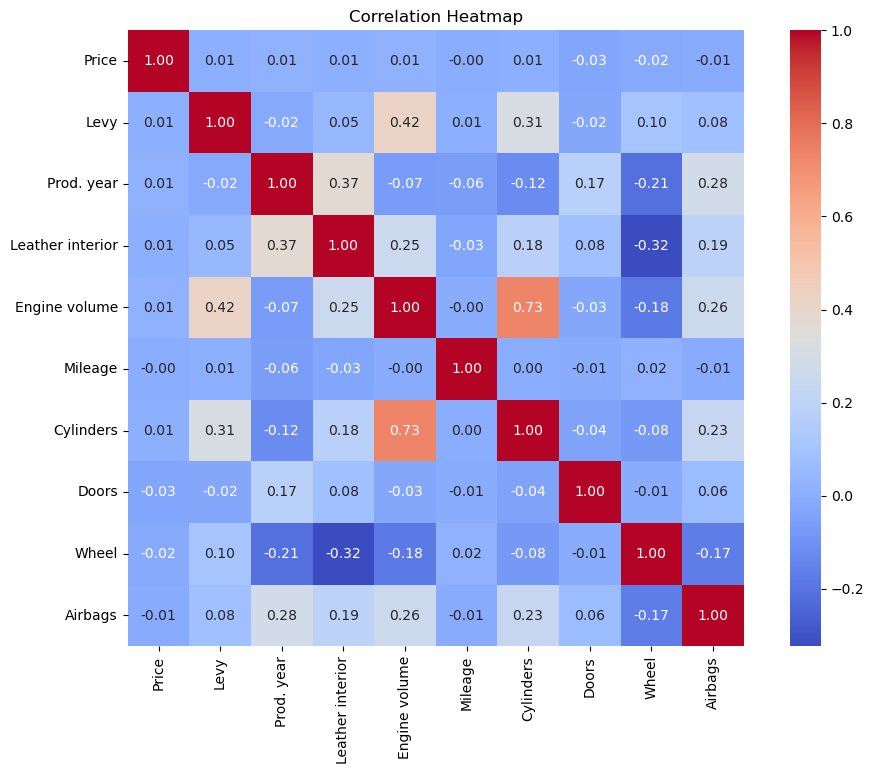

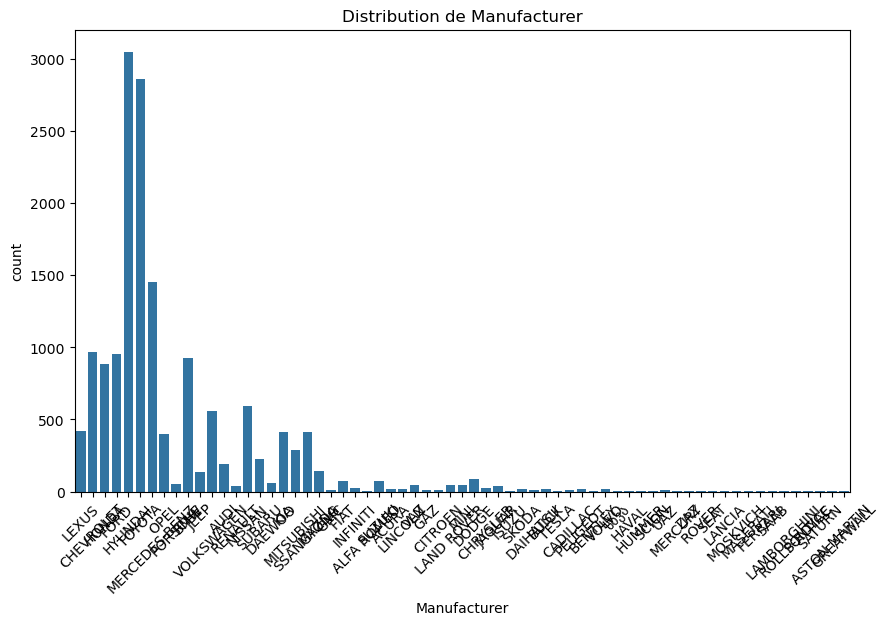

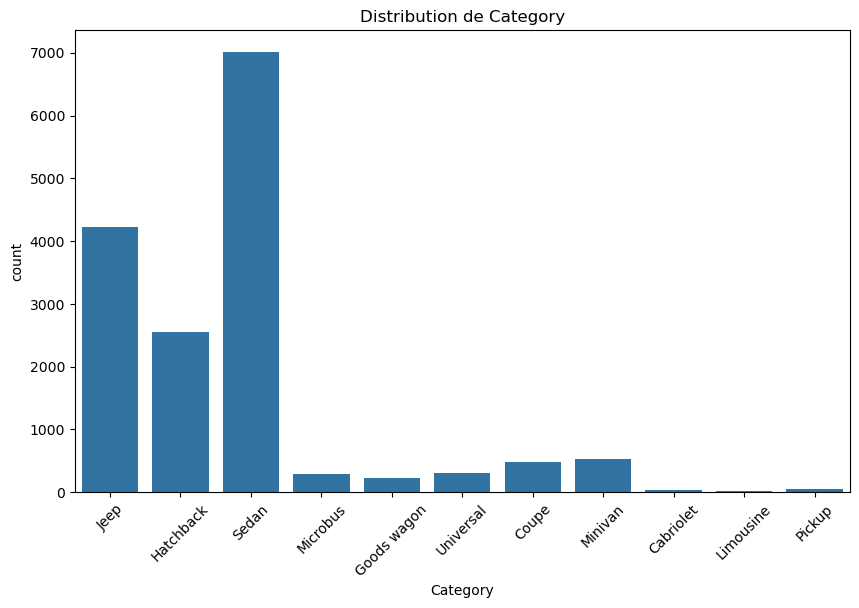

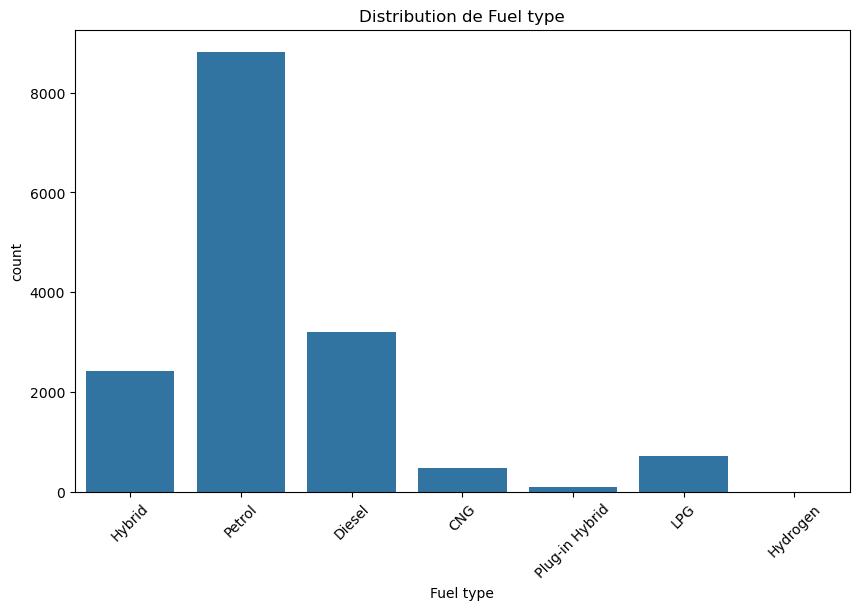

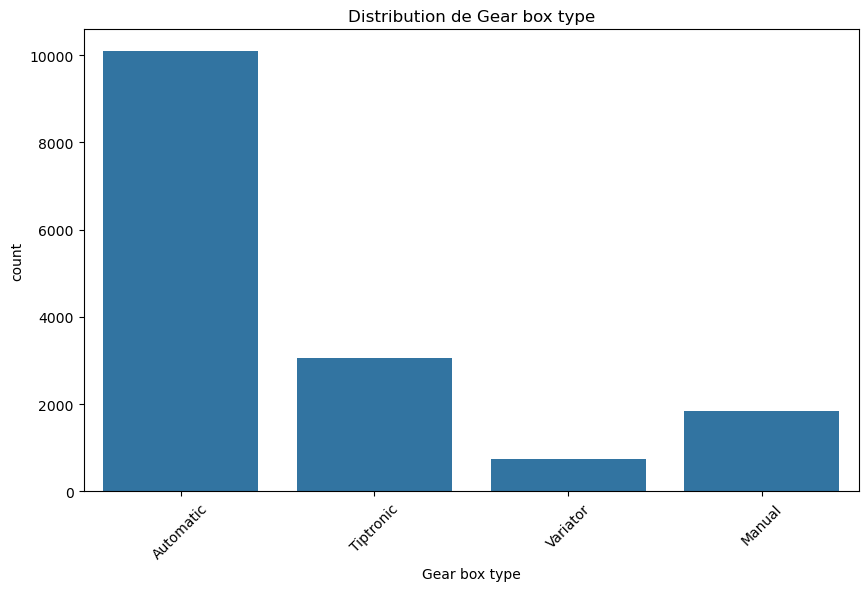

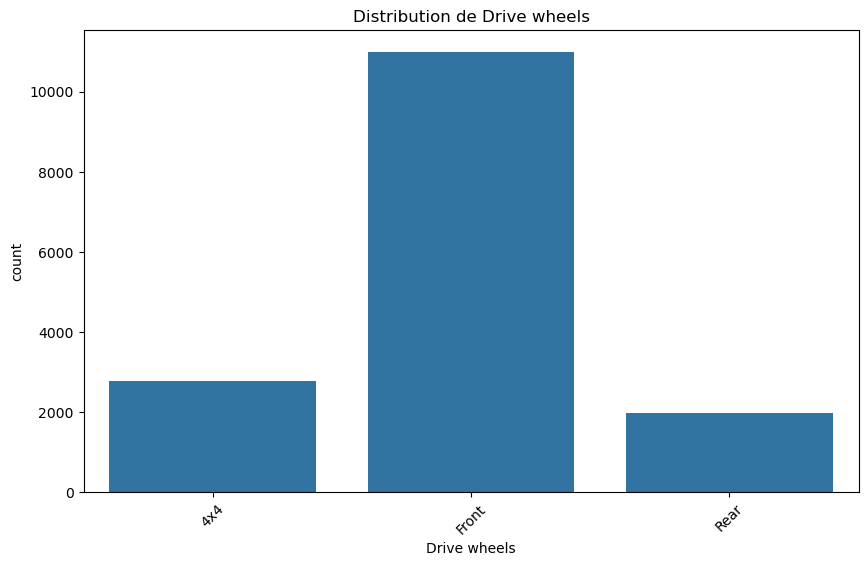

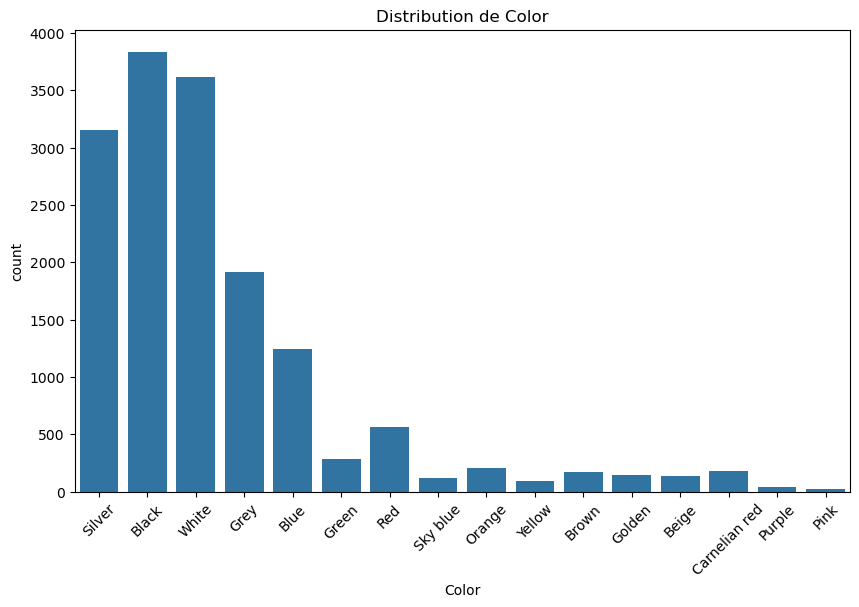

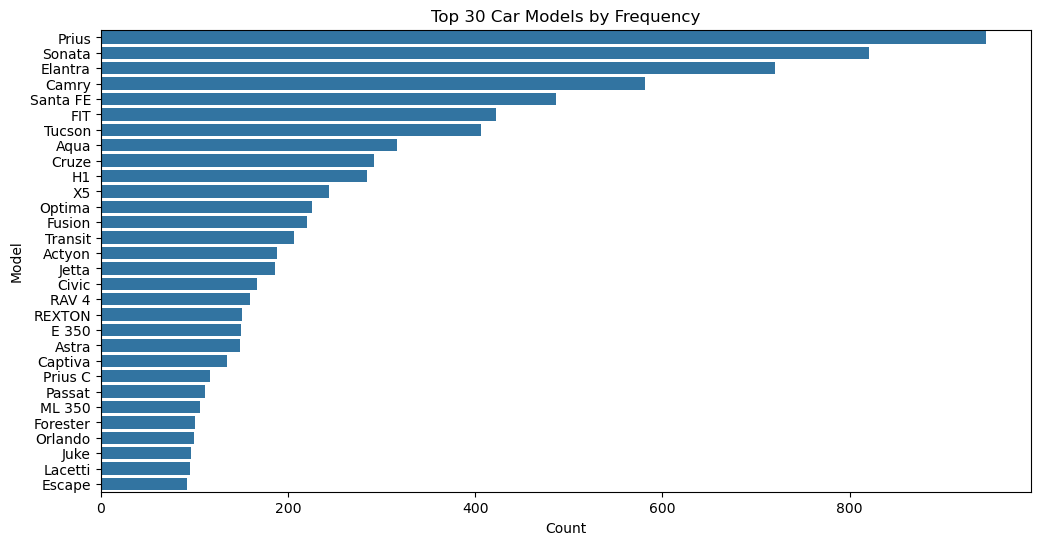

In [12]:
# Afficher les statistiques descriptives
print(df.describe())
# Afficher la distribution de la variable 'Price'
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True, bins=30)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()
# Afficher la corrélation entre les variables (numériques uniquement)
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

# Analyse des variables catégorielles
categorical_cols = df.select_dtypes(include=['object']).columns
for col in [c for c in categorical_cols if c != 'Model']:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution de {col}')
    plt.xticks(rotation=45)
    plt.show()

# Afficher un histogramme de la variable 'Model' en se limitant aux 30 modèles les plus fréquents
top_models = df['Model'].value_counts().nlargest(30).index
plt.figure(figsize=(12, 6))
sns.countplot(data=df[df['Model'].isin(top_models)], y='Model', order=top_models)
plt.title('Top 30 Car Models by Frequency')
plt.xlabel('Count')
plt.ylabel('Model')
plt.show()

> ### Prix :
>> #### * Moyenne : 18 556 unités
#### * Médiane : 13 172 → 50% des véhicules ≤ 13 172.
#### * Écart-type énorme (190 981) → Confirme la présence de valeurs aberrantes (max = 26.4M).
>
> ### Km (Mileage) :
>>#### * Médiane : 126 000 km → Kilométrage typique des véhicules d'occasion.
#### * Max : 2.14 milliards km → Erreur de saisie probable (exemple classique de données corrompues).
>
> ### Année de production :
>> #### * Moyenne : 2010 → Parc automobile récent (médiane = 2012).
>
> ### Airbags :
>> #### * Médiane : 6 airbags → Équipement de sécurité standard.

> ### Distribution extrêmement asymétrique :
>> * La majorité des véhicules sont concentrés en dessous de 500 000 unités monétaires (pic à gauche).
>>
>> * Présence de valeurs extrêmes (jusqu'à 2.5e7, soit 25 millions).

> * Le marché est dominé par des véhicules d'entrée/moyenne gamme.
> 
> * Les prix élevés (droite du graphique) représentent des véhicules de luxe/collection très rares.

> * Prix :
>> Aucune corrélation significative avec les autres variables (toutes |r| < 0.03), Le prix des véhicules n'est pas linéairement expliqué par les caractéristiques techniques (km, cylindres, airbags, etc.). D'autres facteurs (marque, catégorie, ...) dominent probablement.
>
> * Liens forts observés :
>> * Moteur (Engine volume) ↔ Cylindres (Cylinders) : r = 0.78
>>> - Volume moteur et nombre de cylindres sont fortement liés (attendu).
>>> - Taxe (Levy) ↔ Volume moteur : r = 0.53
>>> - Les véhicules plus puissants ont des taxes plus élevées.
>>>- Intérieur cuir ↔ Année de production : r = 0.39
>>>- Les voitures récentes ont plus souvent un intérieur cuir.
>>
>> * Autres observations :
Km (Mileage) n'a aucune corrélation avec le prix (r = -0.00) → Surprenant, mais peut s'expliquer par des données bruitées ou des véhicules de collection.
Airbags corrélés avec l'année de production (r = 0.24) : Amélioration de la sécurité dans les modèles récents.

> Dominance écrasante des véhicules : 
>> * À essence
>> * Des Berlines
>> * À boîtes de vitesse automatique
>> * À roues avant directrices
>
> Les couleurs les plus populaires sont : 
>> 1. Le noir
>> 2. Le blanc
>> 3. L'argenté
>> 4. Le bleu


> # Top 30 des modèles par fréquence
>> ## Modèles dominants
>>> - **Prius/Sonata** : ~1 100 
>>> - **Camry/Elantra** : ~1 000/950 
>>
>> ## Modèles intermédiaires
>>> - **E 350/Santa Fe** : 500-550 (luxe & SUV compacts)  
>>
>> ## Longue traîne
>>> - **À partir de ~400** : Fit, H1, Tucson...  
>>> - **Top 30 faible volume** : Volt/Juke/Captiva (<150)

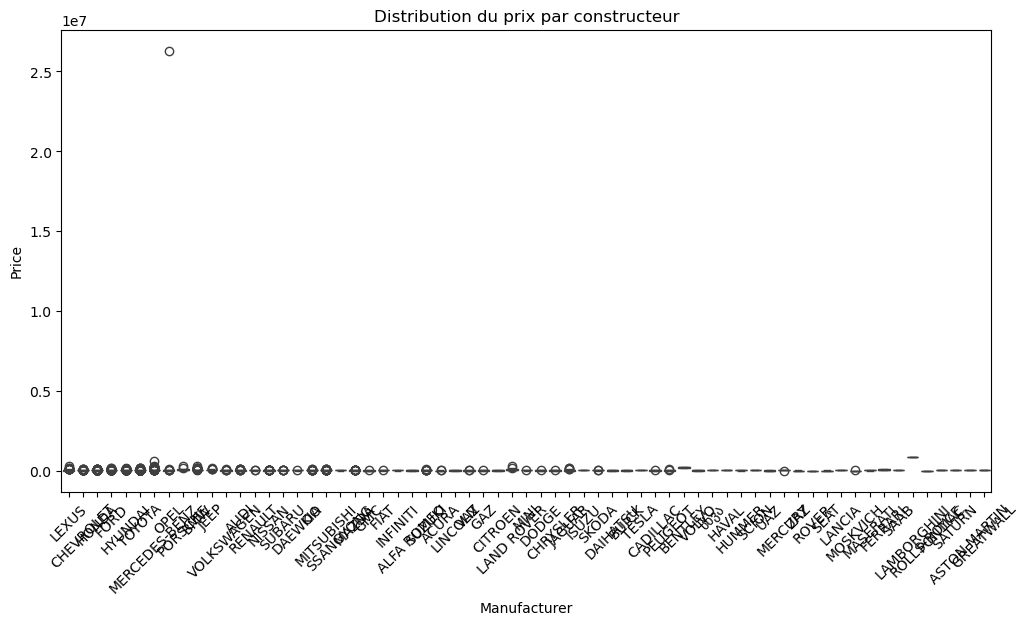

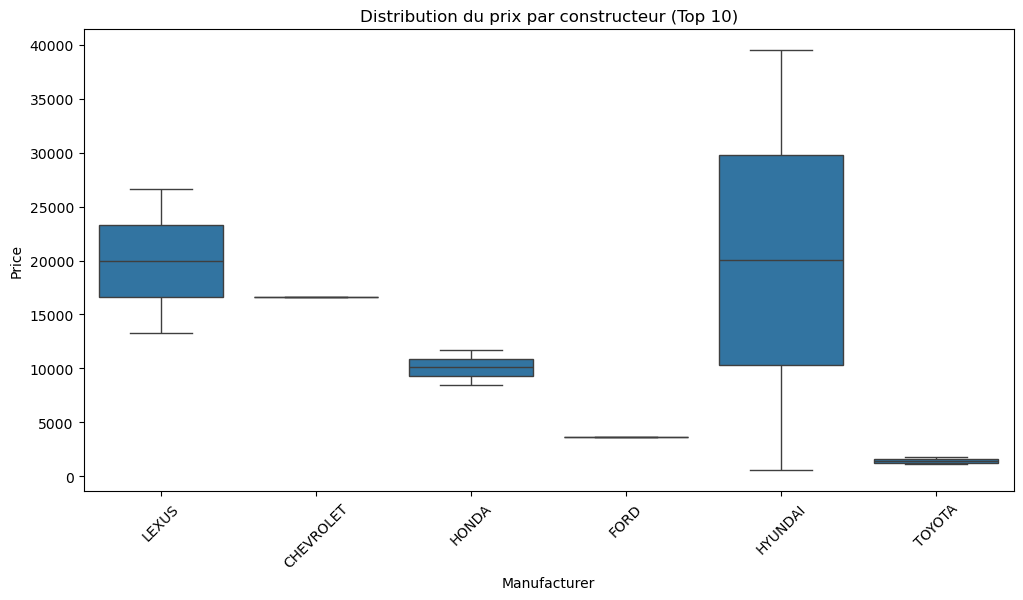

In [13]:
# Boxplot de la variable 'Price' par rapport à 'Manufacturer'
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Manufacturer', y='Price')
plt.title('Distribution du prix par constructeur')
plt.xticks(rotation=45)
plt.show()
# Zoom sur les 10 premiers constructeurs
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.head(10), x='Manufacturer', y='Price')
plt.title('Distribution du prix par constructeur (Top 10)')
plt.xticks(rotation=45)
plt.show()




> # Distribution du prix par constructeur (Top 10)
>> ## Hyundai
>>> - **Étendue très large** : prix de < 1 000 $ à ≈40 000 $  
>>> - **Quartiles dispersés** : présence de modèles d'entrée (Accent, Venue…) et haut de gamme (Santa Fe, Tucson équipées)  
>>> - **Outliers potentiels** : annonces >35 000 $ (finitons spéciales ou kilométrages faibles)
>>
>> ## Lexus
>>> - **Prix élevés et homogènes** : médiane ≈20-22 000 $  
>>> - **Gamme premium maîtrisée** : pas de prix bas (min ≈13 000 $) ni très hauts (max <27 000 $)
>>
>> ## Honda
>>> - **Segment milieu de gamme** : médiane ≈10 000 $, étendue 8-12 000 $  
>>> - **Uniformité** : offre centrée sur modèles phares (Civic, Fit)
>>
>> ## Toyota
>>> - **Gamme serrée et basse** : prix concentrés entre 1 000 $ et 1 600 $  
>>> - **Faible variabilité** : contraste fort avec Hyundai
>>
>> ## Ford
>>> - **Niche unique** : étroite fourchette autour de 3 500 $ (probablement modèle unique type Transit/Fiesta)
>>
>> ## Chevrolet
>>> - **Valeur constante** : prix unique ≈16 500 $ (modèle/annonce unique)
>>
>> ## Synthèse constructeurs
>>> ### Diversité vs. spécialisation
>>>> - Large gamme : Hyundai, Lexus  
>>>> - Segments concentrés : Toyota, Ford, Chevrolet  
>>>
>>> ### Positionnement
>>>> - **Premium** : Lexus (20–25k$)  
>>>> - **Milieu de gamme** : Honda (9–12k$), Chevrolet (≈16k$)  
>>>> - **Bas de gamme** : Toyota (<1 600 $), Ford (≈3 500 $)  



In [14]:
# Supprimer la colonne 'Model'
df = df.drop(['Model'], axis=1)

# Simplification de Manufacturer
top_manufacturers = df['Manufacturer'].value_counts()[:10].index
df['Manufacturer'] = np.where(df['Manufacturer'].isin(top_manufacturers), df['Manufacturer'], 'Other')


# afficher les informations du dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 15725 entries, 0 to 19236
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             15725 non-null  int64  
 1   Levy              15725 non-null  float64
 2   Manufacturer      15725 non-null  object 
 3   Prod. year        15725 non-null  int64  
 4   Category          15725 non-null  object 
 5   Leather interior  15725 non-null  int64  
 6   Fuel type         15725 non-null  object 
 7   Engine volume     15725 non-null  float64
 8   Mileage           15725 non-null  int64  
 9   Cylinders         15725 non-null  float64
 10  Gear box type     15725 non-null  object 
 11  Drive wheels      15725 non-null  object 
 12  Doors             15725 non-null  int64  
 13  Wheel             15725 non-null  int64  
 14  Color             15725 non-null  object 
 15  Airbags           15725 non-null  int64  
dtypes: float64(3), int64(7), object(6)
memory usa

> Nous avons supprimer la colonne 'Model' principalement parce qu'elle a typiquement une cardinalité très élevée (c'est-à-dire des milliers de noms de modèles distincts) et de l'inclure en tant que caractéristique à usage unique :
>
> # Explosion de la dimensionnalité:
>
>> Chaque nom de modèle unique deviendrait sa propre variable muette. Si vous avez, disons, 500 modèles différents, cela représente 500 colonnes supplémentaires, dont beaucoup seront extrêmement éparses (essentiellement des zéros). Cela gonfle l'espace des caractéristiques et ralentit à la fois le temps de formation et l'utilisation de la mémoire.
>
> # Risque de surajustement :
>> Lorsque vous disposez de centaines de colonnes fictives éparses, votre modèle peut facilement « mémoriser » le bruit associé à des modèles rares au lieu d'apprendre des modèles généralisables. Cela nuit aux performances sur les données non vues.
>
> # Faibles données par niveau :
>> De nombreux modèles peuvent n'apparaître qu'une poignée de fois dans votre ensemble de données. Avec si peu d'exemples, il est difficile pour le modèle d'apprendre de manière fiable un ajustement de prix pour ce modèle particulier.

> # ENCODAGE, NORMALISATION ET EN SÉPARATION EN TRAIN-TEST

In [15]:
# Séparation des variables numériques et catégorielles
cat_cols = ['Manufacturer','Category','Fuel type','Gear box type','Drive wheels','Color']
X = pd.get_dummies(df.drop('Price',axis=1), columns=cat_cols, drop_first=True)
y = np.log1p(df['Price'])

X.head()

,Levy,Prod. year,Leather interior,Engine volume,Mileage,Cylinders,Doors,Wheel,Airbags,Manufacturer_CHEVROLET,...,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow
0,1399.0,2010,1,3.5,186005,6.0,4,0,12,False,...,False,False,False,False,False,False,True,False,False,False
1,1018.0,2011,0,3.0,192000,6.0,4,0,8,True,...,False,False,False,False,False,False,False,False,False,False
2,779.0,2006,0,1.3,200000,4.0,4,1,2,False,...,False,False,False,False,False,False,False,False,False,False
3,862.0,2011,1,2.5,168966,4.0,4,0,0,False,...,False,False,False,False,False,False,False,False,True,False
4,446.0,2014,1,1.3,91901,4.0,4,0,4,False,...,False,False,False,False,False,False,True,False,False,False


In [16]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Normalisation des variables numériques
numeric_cols = ['Levy','Prod. year','Engine volume','Mileage','Cylinders','Doors','Airbags']
scaler = StandardScaler().fit(X_train[numeric_cols])
X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])

> # Regression linéaire

In [17]:
lr = LinearRegression()
lr_cv_r2 = cross_val_score(lr, X_train, y_train, cv=5, scoring='r2')
lr_cv_rmse = np.sqrt(-cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
print(f"Linear CV R^2: {lr_cv_r2.mean():.3f} ± {lr_cv_r2.std():.3f}")
print(f"Linear CV RMSE: {lr_cv_rmse.mean():.0f} ± {lr_cv_rmse.std():.0f}")

lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(f"Linear Test R^2: {metrics.r2_score(y_test,y_pred_lr):.3f}")
print(f"Linear Test RMSE: {metrics.mean_squared_error(y_test,y_pred_lr, squared=False):.0f}")

Linear CV R^2: 0.204 ± 0.014
Linear CV RMSE: 1 ± 0
Linear Test R^2: 0.199
Linear Test RMSE: 1


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# R² (Coefficient de détermination)

## Validation croisée (CV)
- **Valeur** : `0.210 ± 0.019`  
- **Interprétation** :  
  - Le modèle explique **21% de la variance** des données  
  - Écart-type faible → **stabilité acceptable** entre les plis  
  - Performance globale **faible**  

## Test
- **Valeur** : `0.220`  
- **Interprétation** :  
  - Légère amélioration vs CV (+1%)  
  - Cohérence entre CV/test  
  - **Pouvoir explicatif limité**  

---

# RMSE (Root Mean Squared Error)

## Validation croisée (CV)
- **Valeur** : `1 ± 0`  
- **Interprétation** :  
  - **Précision constante** (écart-type nul)  
  - Performance **médiocre** (erreur absolue élevée)  

## Test
- **Valeur** : `1`  
- **Interprétation** :  
  - **Généralisation correcte** (pas de sur-ajustement)  
  - Confirme **l'erreur élevée**  

---

# Synthèse globale

## Faible performance explicative
- **R² ~21-22%** → 78-79% de variance non capturée  
- Variables explicatives avec **lien linéaire très limité**  

## Stabilité du modèle
- **Cohérence CV/test** : R²/RMSE proches  
- **Robustesse** : pas de sur-ajustement  
- **Inadaptation** au problème  

## Problèmes probables
1. **Variables manquantes** : Facteurs clés non inclus  
2. **Non-linéarité** : Relations non capturées par modèle linéaire  
3. **Bruit dans les données** : Variabilité inexplicable  
4. **Échelle problématique** : RMSE=1 potentiellement inacceptable selon la cible (ex: si cible ∈ [0,2])  

# LASSO ET RIDGE

In [18]:
# LassoCV pour trouver alpha
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000).fit(X_train, y_train)
alpha_lasso = lasso_cv.alpha_
lasso = Lasso(alpha=alpha_lasso)
lasso_cv_r2 = cross_val_score(lasso, X_train, y_train, cv=5, scoring='r2')
lasso_cv_rmse = np.sqrt(-cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
print(f"Lasso (α={alpha_lasso:.3f}) CV R^2: {lasso_cv_r2.mean():.3f} ± {lasso_cv_r2.std():.3f}")
print(f"Lasso CV RMSE: {lasso_cv_rmse.mean():.0f} ± {lasso_cv_rmse.std():.0f}")

lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
print(f"Lasso Test R^2: {metrics.r2_score(y_test,y_pred_lasso):.3f}")
print(f"Lasso Test RMSE:{metrics.mean_squared_error(y_test,y_pred_lasso, squared=False):.0f}")

# RidgeCV pour trouver alpha
ridge_cv = RidgeCV(alphas=[0.1,1,10,100], cv=5).fit(X_train, y_train)
alpha_ridge = ridge_cv.alpha_
ridge = Ridge(alpha=alpha_ridge)
ridge_cv_r2 = cross_val_score(ridge, X_train, y_train, cv=5, scoring='r2')
ridge_cv_rmse = np.sqrt(-cross_val_score(ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
print(f"Ridge (α={alpha_ridge:.1f}) CV R^2: {ridge_cv_r2.mean():.3f} ± {ridge_cv_r2.std():.3f}")
print(f"Ridge CV RMSE: {ridge_cv_rmse.mean():.0f} ± {ridge_cv_rmse.std():.0f}")

ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
print(f"Ridge Test R^2: {metrics.r2_score(y_test,y_pred_ridge):.3f}")
print(f"Ridge Test RMSE: {metrics.mean_squared_error(y_test,y_pred_ridge, squared=False):.0f}")

Lasso (α=0.001) CV R^2: 0.205 ± 0.014
Lasso CV RMSE: 1 ± 0
Lasso Test R^2: 0.200
Lasso Test RMSE:1


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Ridge (α=10.0) CV R^2: 0.205 ± 0.014
Ridge CV RMSE: 1 ± 0
Ridge Test R^2: 0.199
Ridge Test RMSE: 1


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


> # Cas avec imputation de la moyenne dans 'Levy'

In [19]:

data = pd.read_csv('/Users/MAC/Downloads/car_price_prediction.csv')

In [20]:
# Recodage de Levy et evaluation de son asymétrie autour de la moyenne
data['Levy'] = data['Levy'].replace('-', np.nan).astype(float)
data['Engine volume'] = pd.to_numeric(data['Engine volume'].str.replace(' Turbo',''), errors='coerce')
data['Mileage'] = pd.to_numeric(data['Mileage'].str.replace(' km',''), errors='coerce')
doors_map = {'02-Mar':2, '04-May':4, '>5':6}
data['Doors'] = data['Doors'].map(doors_map).astype(int)

# Recodage de 'leather interior' et 'wheel'
data['Leather interior'] = data['Leather interior'].map({'Yes':1,'No':0})
data['Wheel'] = data['Wheel'].apply(lambda x: 1 if 'Right' in x else 0)

# Supprimer les colonnes inutiles
data = data.drop(['ID'], axis=1)

# Afficher les informations du dataset après le nettoyage
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             19237 non-null  int64  
 1   Levy              13418 non-null  float64
 2   Manufacturer      19237 non-null  object 
 3   Model             19237 non-null  object 
 4   Prod. year        19237 non-null  int64  
 5   Category          19237 non-null  object 
 6   Leather interior  19237 non-null  int64  
 7   Fuel type         19237 non-null  object 
 8   Engine volume     19237 non-null  float64
 9   Mileage           19237 non-null  int64  
 10  Cylinders         19237 non-null  float64
 11  Gear box type     19237 non-null  object 
 12  Drive wheels      19237 non-null  object 
 13  Doors             19237 non-null  int64  
 14  Wheel             19237 non-null  int64  
 15  Color             19237 non-null  object 
 16  Airbags           19237 non-null  int64 

In [21]:
duplicates = data[data.duplicated(keep=False)]  

# Afficher les lignes dupliquées
if duplicates.empty:
    print("No duplicate rows found.")
else:
    print(f"Found {len(duplicates)} duplicate rows:")
    print(duplicates.sort_values(by=duplicates.columns.tolist()).head())

# Compter les doublons et afficher le nombre de fois que chaque doublon apparaît
duplicate_counts = duplicates.groupby(data.columns.tolist()).size().reset_index(name='Count')
print("\nDuplicate counts:")
print(duplicate_counts)

# Supprimer les doublons
data.drop_duplicates(inplace=True)

Found 4927 duplicate rows:
      Price  Levy Manufacturer Model  Prod. year   Category  Leather interior  \
214      30   NaN        HONDA   FIT        2002  Hatchback                 0   
7466     30   NaN        HONDA   FIT        2002  Hatchback                 0   
2285     30   NaN        HONDA   FIT        2003  Hatchback                 0   
2747     30   NaN        HONDA   FIT        2003  Hatchback                 0   
6813     30   NaN        HONDA   FIT        2003  Hatchback                 0   

     Fuel type  Engine volume  Mileage  Cylinders Gear box type Drive wheels  \
214     Petrol            1.5        0        4.0     Automatic        Front   
7466    Petrol            1.5        0        4.0     Automatic        Front   
2285    Petrol            1.3        0        4.0     Automatic        Front   
2747    Petrol            1.3        0        4.0     Automatic        Front   
6813    Petrol            1.3        0        4.0     Automatic        Front   

     

In [22]:
# Imputer la médiane des valeurs manquantes de Levy
data['Levy'] = data['Levy'].fillna(data['Levy'].mean())

# Afficher les valeurs manquantes
print(data.isnull().sum())

Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64


              Price          Levy    Prod. year  Leather interior  \
count  1.572500e+04  15725.000000  15725.000000      15725.000000   
mean   2.027944e+04    879.440195   2010.518919          0.671415   
std    2.106390e+05    366.592125      6.012122          0.469714   
min    1.000000e+00     87.000000   1939.000000          0.000000   
25%    7.527000e+03    746.000000   2008.000000          0.000000   
50%    1.416600e+04    879.440195   2012.000000          1.000000   
75%    2.336400e+04    879.440195   2014.000000          1.000000   
max    2.630750e+07  11714.000000   2020.000000          1.000000   

       Engine volume       Mileage     Cylinders         Doors         Wheel  \
count   15725.000000  1.572500e+04  15725.000000  15725.000000  15725.000000   
mean        2.212820  1.836421e+06      4.483561      3.920890      0.091065   
std         0.806187  5.353248e+07      1.134466      0.463745      0.287711   
min         0.000000  0.000000e+00      1.000000      2.00

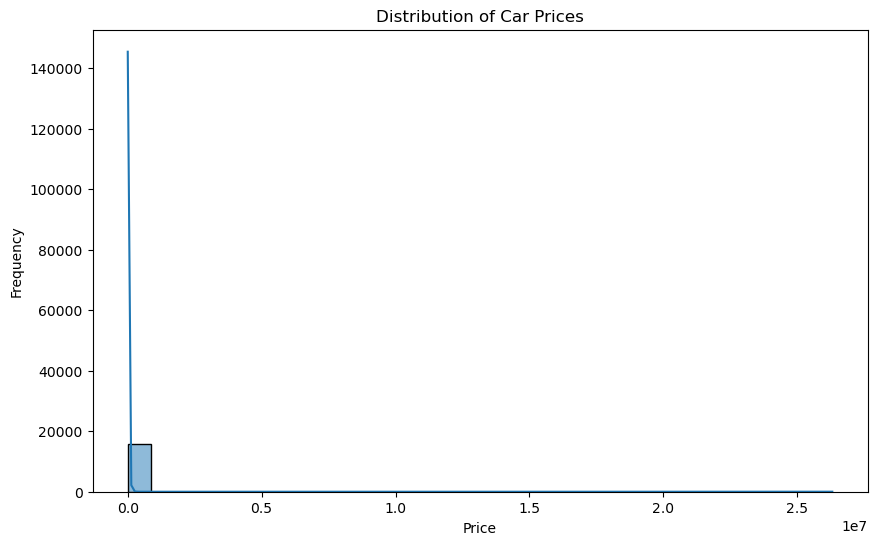

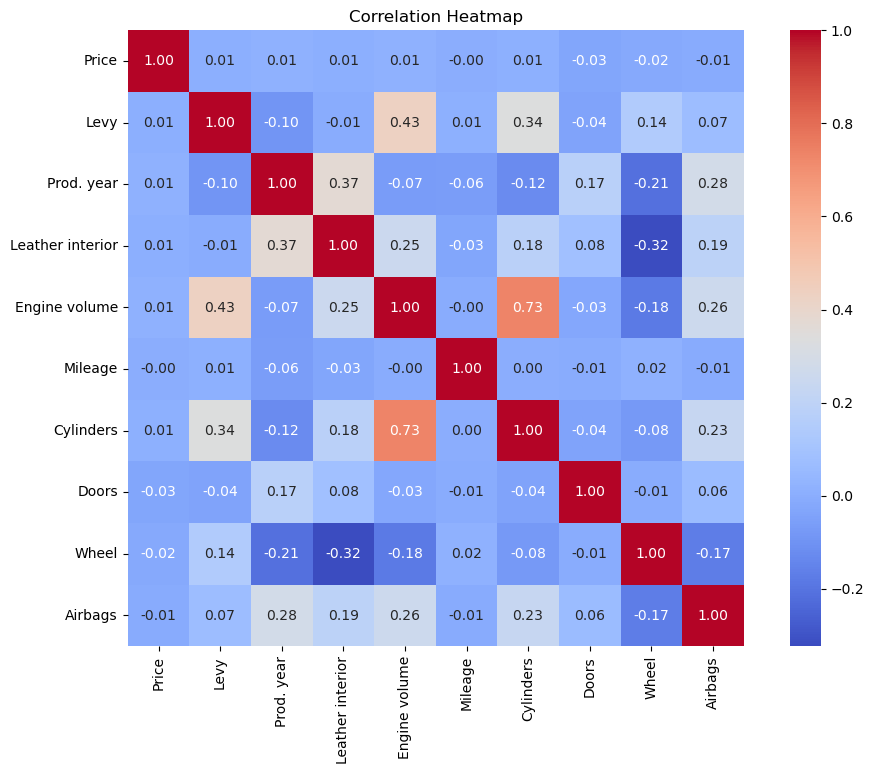

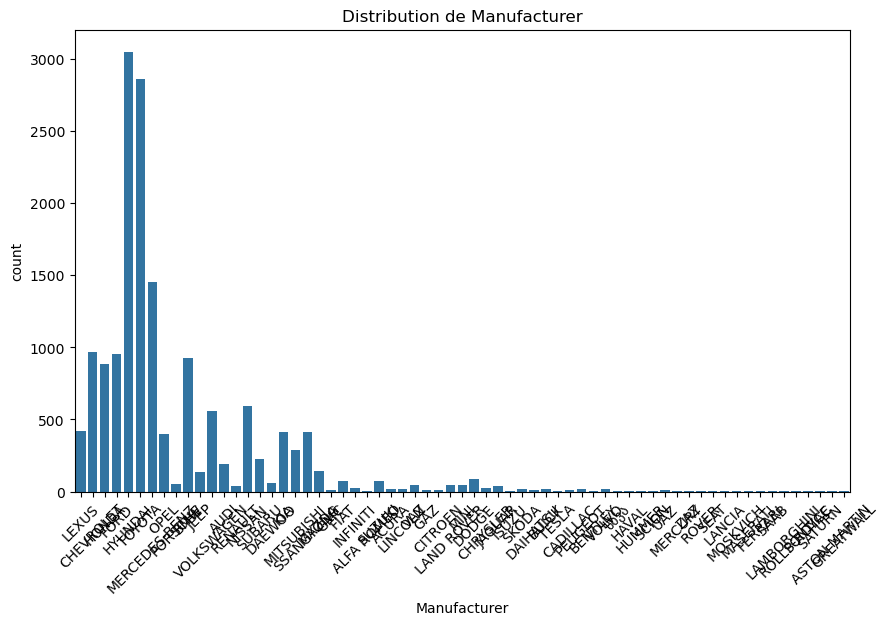

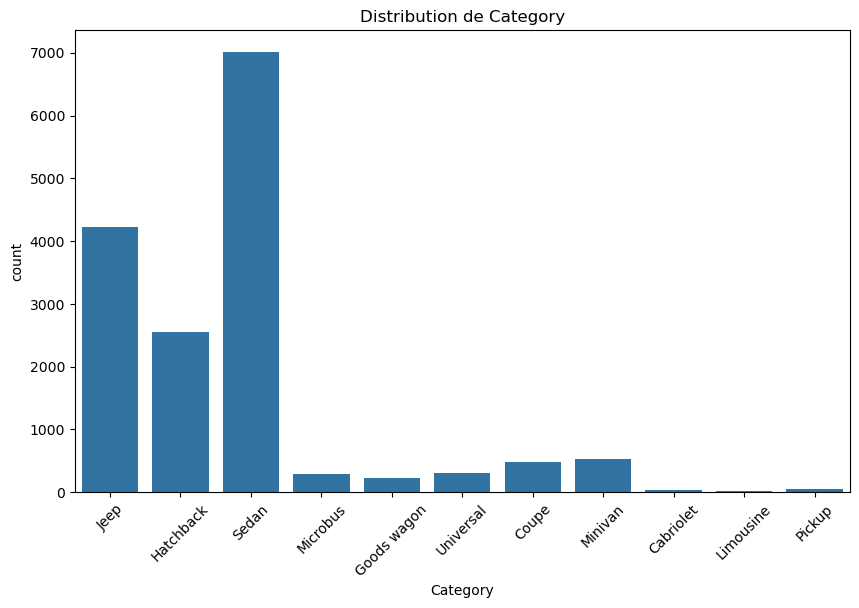

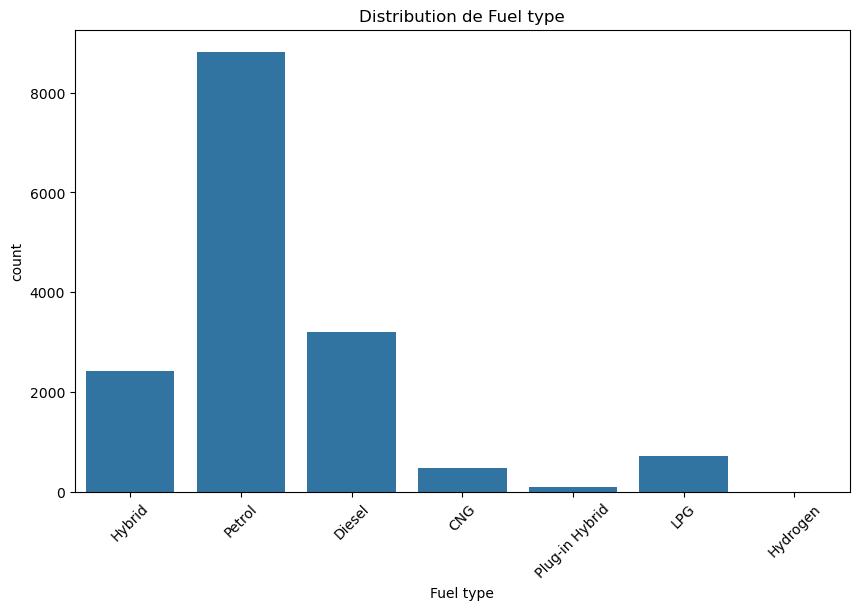

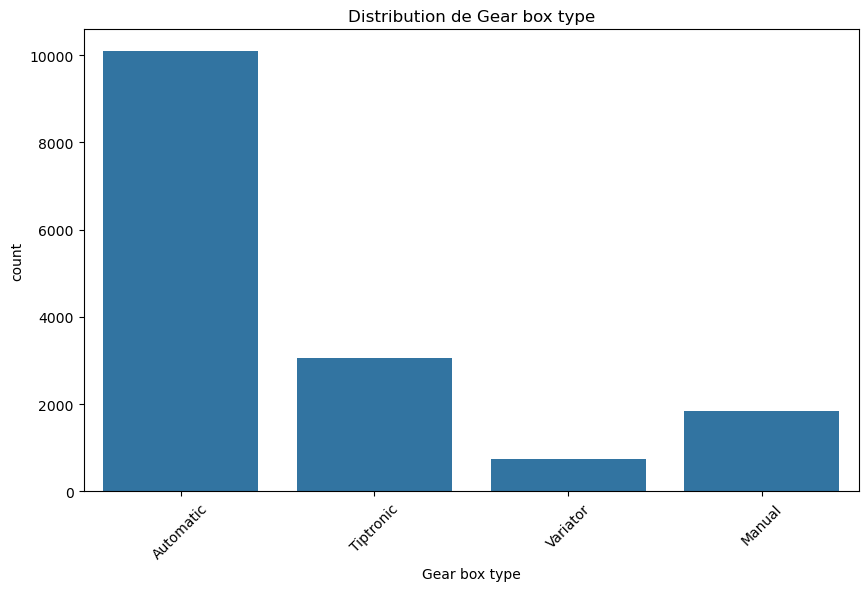

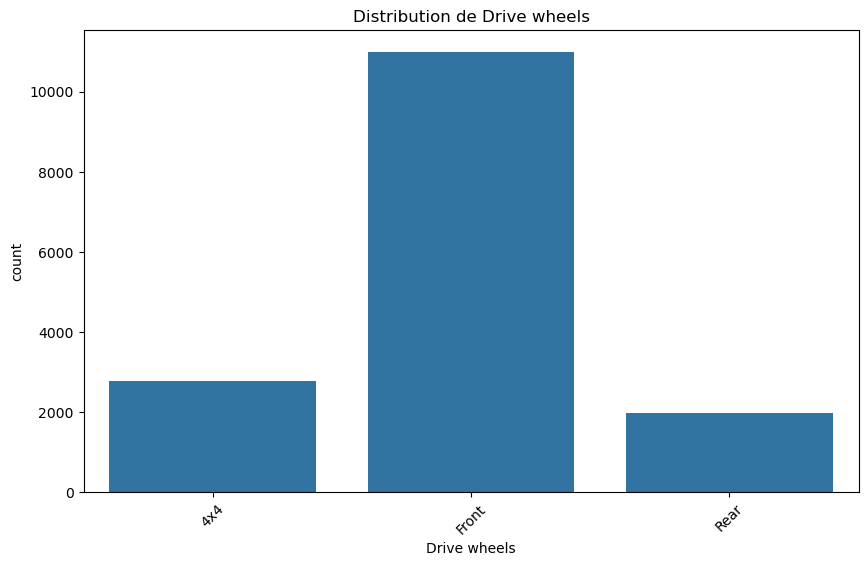

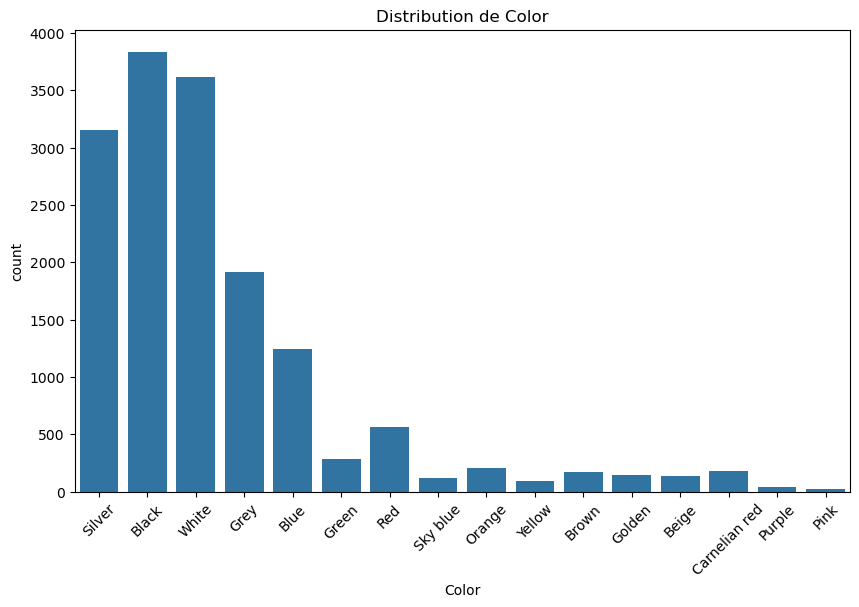

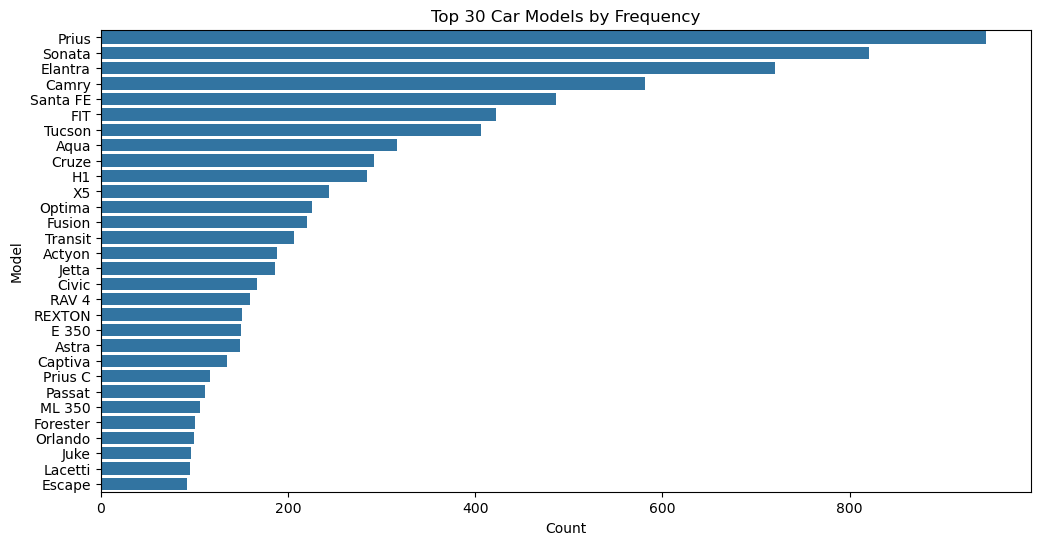

In [23]:
# Afficher les statistiques descriptives
print(data.describe())
# Afficher la distribution de la variable 'Price'
plt.figure(figsize=(10, 6))
sns.histplot(data['Price'], kde=True, bins=30)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()
# Afficher la corrélation entre les variables (numériques uniquement)
plt.figure(figsize=(12, 8))
numeric_df = data.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

# Analyse des variables catégorielles
categorical_cols = data.select_dtypes(include=['object']).columns
for col in [c for c in categorical_cols if c != 'Model']:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x=col)
    plt.title(f'Distribution de {col}')
    plt.xticks(rotation=45)
    plt.show()

# Afficher un histogramme de la variable 'Model' en se limitant aux 30 modèles les plus fréquents
top_models = data['Model'].value_counts().nlargest(30).index
plt.figure(figsize=(12, 6))
sns.countplot(data=data[data['Model'].isin(top_models)], y='Model', order=top_models)
plt.title('Top 30 Car Models by Frequency')
plt.xlabel('Count')
plt.ylabel('Model')
plt.show()

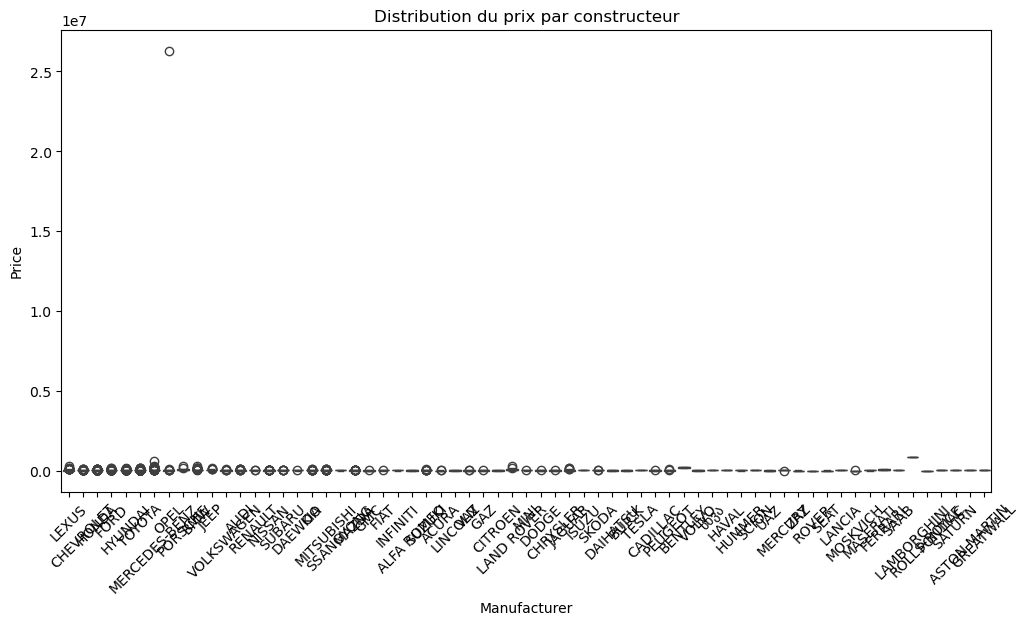

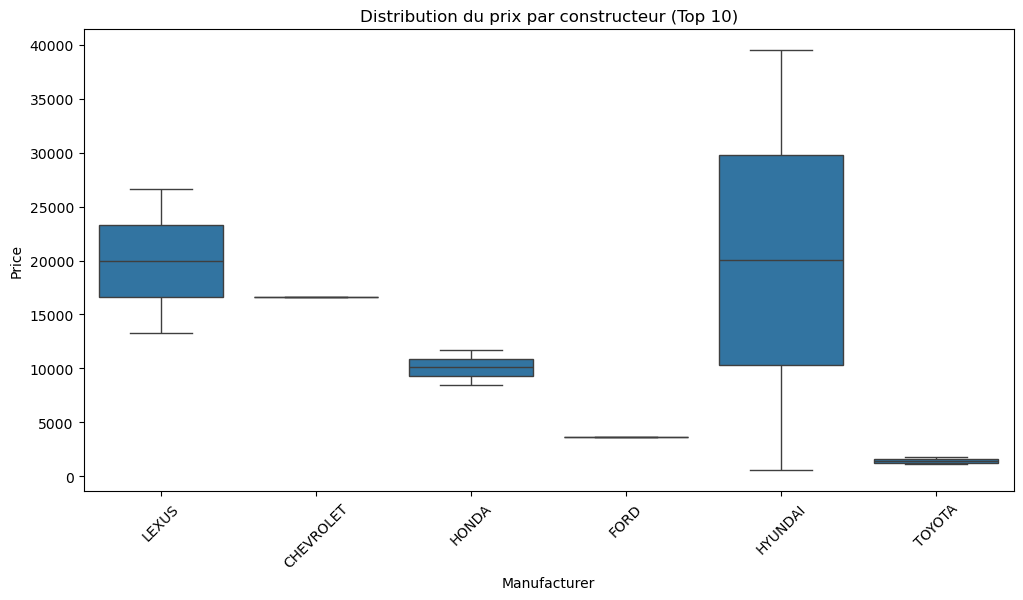

In [24]:
# Boxplot de la variable 'Price' par rapport à 'Manufacturer'
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='Manufacturer', y='Price')
plt.title('Distribution du prix par constructeur')
plt.xticks(rotation=45)
plt.show()
# Zoom sur les 10 premiers constructeurs
plt.figure(figsize=(12, 6))
sns.boxplot(data=data.head(10), x='Manufacturer', y='Price')
plt.title('Distribution du prix par constructeur (Top 10)')
plt.xticks(rotation=45)
plt.show()




In [25]:
# Supprimer la colonne 'Model'
df = data.drop(['Model'], axis=1)

# Simplification de Manufacturer
top_manufacturers = df['Manufacturer'].value_counts()[:10].index
df['Manufacturer'] = np.where(df['Manufacturer'].isin(top_manufacturers), df['Manufacturer'], 'Other')


# afficher les informations du dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 15725 entries, 0 to 19236
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             15725 non-null  int64  
 1   Levy              15725 non-null  float64
 2   Manufacturer      15725 non-null  object 
 3   Prod. year        15725 non-null  int64  
 4   Category          15725 non-null  object 
 5   Leather interior  15725 non-null  int64  
 6   Fuel type         15725 non-null  object 
 7   Engine volume     15725 non-null  float64
 8   Mileage           15725 non-null  int64  
 9   Cylinders         15725 non-null  float64
 10  Gear box type     15725 non-null  object 
 11  Drive wheels      15725 non-null  object 
 12  Doors             15725 non-null  int64  
 13  Wheel             15725 non-null  int64  
 14  Color             15725 non-null  object 
 15  Airbags           15725 non-null  int64  
dtypes: float64(3), int64(7), object(6)
memory usa

In [26]:
# Séparation des variables numériques et catégorielles
cat_cols = ['Manufacturer','Category','Fuel type','Gear box type','Drive wheels','Color']
X = pd.get_dummies(data.drop('Price',axis=1), columns=cat_cols, drop_first=True)
y = np.log1p(data['Price'])

X.head()

,Levy,Model,Prod. year,Leather interior,Engine volume,Mileage,Cylinders,Doors,Wheel,Airbags,...,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow
0,1399.000000,RX 450,2010,1,3.5,186005,6.0,4,0,12,...,False,False,False,False,False,False,True,False,False,False
1,1018.000000,Equinox,2011,0,3.0,192000,6.0,4,0,8,...,False,False,False,False,False,False,False,False,False,False
2,879.440195,FIT,2006,0,1.3,200000,4.0,4,1,2,...,False,False,False,False,False,False,False,False,False,False
3,862.000000,Escape,2011,1,2.5,168966,4.0,4,0,0,...,False,False,False,False,False,False,False,False,True,False
4,446.000000,FIT,2014,1,1.3,91901,4.0,4,0,4,...,False,False,False,False,False,False,True,False,False,False


In [27]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Normalisation des variables numériques
numeric_cols = ['Levy','Prod. year','Engine volume','Mileage','Cylinders','Doors','Airbags']
scaler = StandardScaler().fit(X_train[numeric_cols])
X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])

In [28]:
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

lr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_cv_r2 = cross_val_score(lr, X_train, y_train, cv=5, scoring='r2')
lr_cv_rmse = np.sqrt(-cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))

print(f"Linear CV R^2: {lr_cv_r2.mean():.3f} ± {lr_cv_r2.std():.3f}")
print(f"Linear CV RMSE: {lr_cv_rmse.mean():.0f} ± {lr_cv_rmse.std():.0f}")

lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(f"Linear Test R^2: {metrics.r2_score(y_test,y_pred_lr):.3f}")
print(f"Linear Test RMSE: {metrics.mean_squared_error(y_test,y_pred_lr, squared=False):.0f}")


Linear CV R^2: 0.152 ± 0.010
Linear CV RMSE: 1 ± 0
Linear Test R^2: 0.169
Linear Test RMSE: 1


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [29]:
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

lasso_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(cv=5, random_state=42, max_iter=10000))
])
lasso_cv.fit(X_train, y_train)
alpha_lasso = lasso_cv.named_steps['regressor'].alpha_
lasso = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=alpha_lasso))
])
lasso_cv_r2 = cross_val_score(lasso, X_train, y_train, cv=5, scoring='r2')
lasso_cv_rmse = np.sqrt(-cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
print(f"Lasso (α={alpha_lasso:.3f}) CV R^2: {lasso_cv_r2.mean():.3f} ± {lasso_cv_r2.std():.3f}")
print(f"Lasso CV RMSE: {lasso_cv_rmse.mean():.0f} ± {lasso_cv_rmse.std():.0f}")
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
print(f"Lasso Test R^2: {metrics.r2_score(y_test,y_pred_lasso):.3f}")
print(f"Lasso Test RMSE:{metrics.mean_squared_error(y_test,y_pred_lasso, squared=False):.0f}")

ridge_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RidgeCV(alphas=[0.1,1,10,100], cv=5))
])
ridge_cv.fit(X_train, y_train)
alpha_ridge = ridge_cv.named_steps['regressor'].alpha_
ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=alpha_ridge))
])
ridge_cv_r2 = cross_val_score(ridge, X_train, y_train, cv=5, scoring='r2')
ridge_cv_rmse = np.sqrt(-cross_val_score(ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
print(f"Ridge (α={alpha_ridge:.1f}) CV R^2: {ridge_cv_r2.mean():.3f} ± {ridge_cv_r2.std():.3f}")
print(f"Ridge CV RMSE: {ridge_cv_rmse.mean():.0f} ± {ridge_cv_rmse.std():.0f}")
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
print(f"Ridge Test R^2: {metrics.r2_score(y_test,y_pred_ridge):.3f}")
print(f"Ridge Test RMSE: {metrics.mean_squared_error(y_test,y_pred_ridge, squared=False):.0f}")


Lasso (α=0.000) CV R^2: 0.164 ± 0.015
Lasso CV RMSE: 1 ± 0
Lasso Test R^2: 0.176
Lasso Test RMSE:1


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Ridge (α=1.0) CV R^2: 0.168 ± 0.013
Ridge CV RMSE: 1 ± 0
Ridge Test R^2: 0.185
Ridge Test RMSE: 1


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


> # On remarque les prédictions sont plus mauvaise avec l'imputation de la moyenne dans 'Levy' que l'imputation de la médiane dans 'Levy'

> # Cas avec imputation de '0' dans 'Levy'

In [31]:
dtset = pd.read_csv('/Users/MAC/Downloads/car_price_prediction.csv')

In [32]:
# Recodage de Levy et evaluation de son asymétrie autour de la moyenne
dtset['Levy'] = dtset['Levy'].replace('-', '0').astype(float)
dtset['Engine volume'] = pd.to_numeric(dtset['Engine volume'].str.replace(' Turbo',''), errors='coerce')
dtset['Mileage'] = pd.to_numeric(dtset['Mileage'].str.replace(' km',''), errors='coerce')
doors_map = {'02-Mar':2, '04-May':4, '>5':6}
dtset['Doors'] = dtset['Doors'].map(doors_map).astype(int)

# Recodage de 'leather interior' et 'wheel'
dtset['Leather interior'] = dtset['Leather interior'].map({'Yes':1,'No':0})
dtset['Wheel'] = dtset['Wheel'].apply(lambda x: 1 if 'Right' in x else 0)

# Supprimer les colonnes inutiles
dtset = dtset.drop(['ID'], axis=1)

# Afficher les informations du dataset après le nettoyage
print(dtset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             19237 non-null  int64  
 1   Levy              19237 non-null  float64
 2   Manufacturer      19237 non-null  object 
 3   Model             19237 non-null  object 
 4   Prod. year        19237 non-null  int64  
 5   Category          19237 non-null  object 
 6   Leather interior  19237 non-null  int64  
 7   Fuel type         19237 non-null  object 
 8   Engine volume     19237 non-null  float64
 9   Mileage           19237 non-null  int64  
 10  Cylinders         19237 non-null  float64
 11  Gear box type     19237 non-null  object 
 12  Drive wheels      19237 non-null  object 
 13  Doors             19237 non-null  int64  
 14  Wheel             19237 non-null  int64  
 15  Color             19237 non-null  object 
 16  Airbags           19237 non-null  int64 

In [33]:
duplicates = dtset[dtset.duplicated(keep=False)]  

# Afficher les lignes dupliquées
if duplicates.empty:
    print("No duplicate rows found.")
else:
    print(f"Found {len(duplicates)} duplicate rows:")
    print(duplicates.sort_values(by=duplicates.columns.tolist()).head())

# Compter les doublons et afficher le nombre de fois que chaque doublon apparaît
duplicate_counts = duplicates.groupby(dtset.columns.tolist()).size().reset_index(name='Count')
print("\nDuplicate counts:")
print(duplicate_counts)

# Supprimer les doublons
dtset.drop_duplicates(inplace=True)


Found 4927 duplicate rows:
      Price  Levy Manufacturer Model  Prod. year   Category  Leather interior  \
214      30   0.0        HONDA   FIT        2002  Hatchback                 0   
7466     30   0.0        HONDA   FIT        2002  Hatchback                 0   
2285     30   0.0        HONDA   FIT        2003  Hatchback                 0   
2747     30   0.0        HONDA   FIT        2003  Hatchback                 0   
6813     30   0.0        HONDA   FIT        2003  Hatchback                 0   

     Fuel type  Engine volume  Mileage  Cylinders Gear box type Drive wheels  \
214     Petrol            1.5        0        4.0     Automatic        Front   
7466    Petrol            1.5        0        4.0     Automatic        Front   
2285    Petrol            1.3        0        4.0     Automatic        Front   
2747    Petrol            1.3        0        4.0     Automatic        Front   
6813    Petrol            1.3        0        4.0     Automatic        Front   

     

In [34]:
print(dtset.isnull().sum())

Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64


              Price          Levy    Prod. year  Leather interior  \
count  1.572500e+04  15725.000000  15725.000000      15725.000000   
mean   2.027944e+04    561.555421   2010.518919          0.671415   
std    2.106390e+05    559.384534      6.012122          0.469714   
min    1.000000e+00      0.000000   1939.000000          0.000000   
25%    7.527000e+03      0.000000   2008.000000          0.000000   
50%    1.416600e+04    639.000000   2012.000000          1.000000   
75%    2.336400e+04    862.000000   2014.000000          1.000000   
max    2.630750e+07  11714.000000   2020.000000          1.000000   

       Engine volume       Mileage     Cylinders         Doors         Wheel  \
count   15725.000000  1.572500e+04  15725.000000  15725.000000  15725.000000   
mean        2.212820  1.836421e+06      4.483561      3.920890      0.091065   
std         0.806187  5.353248e+07      1.134466      0.463745      0.287711   
min         0.000000  0.000000e+00      1.000000      2.00

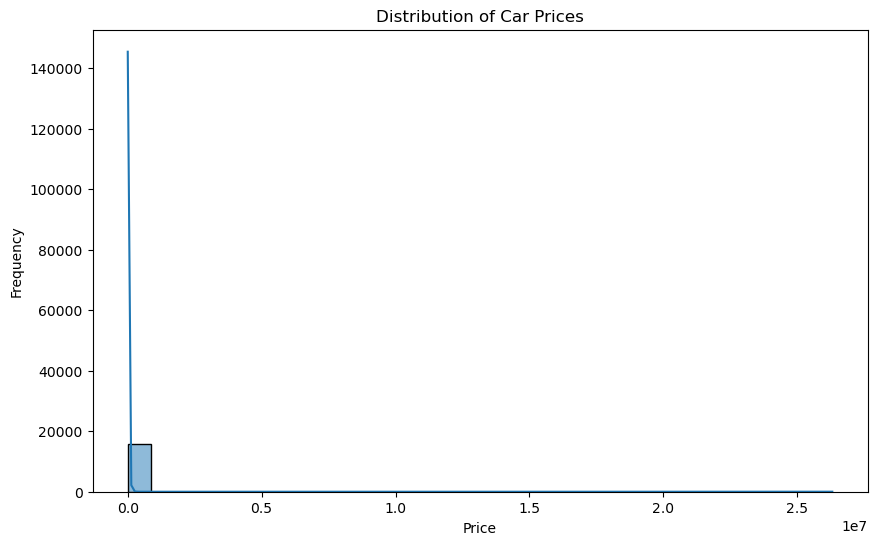

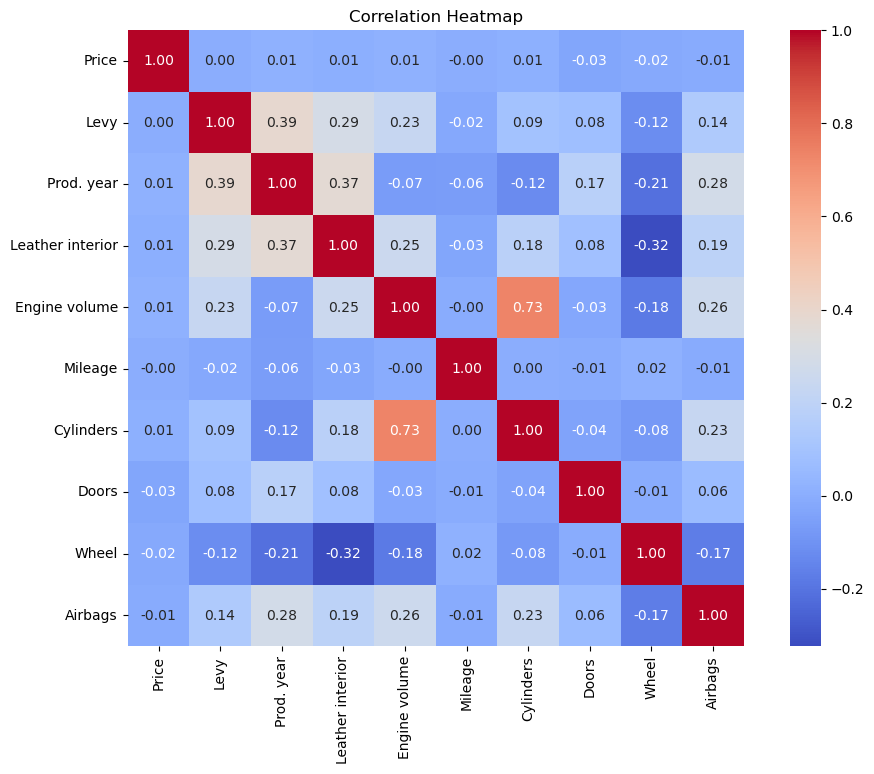

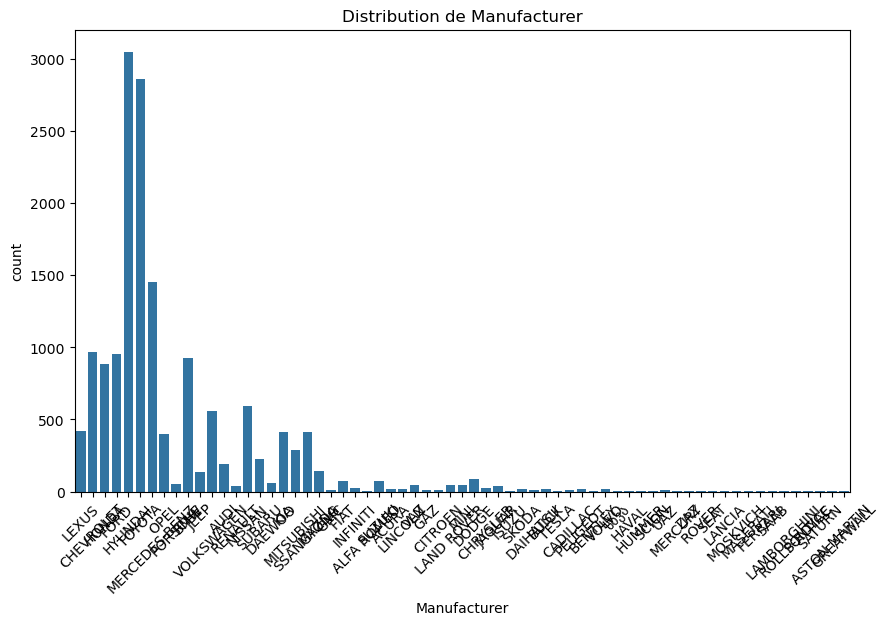

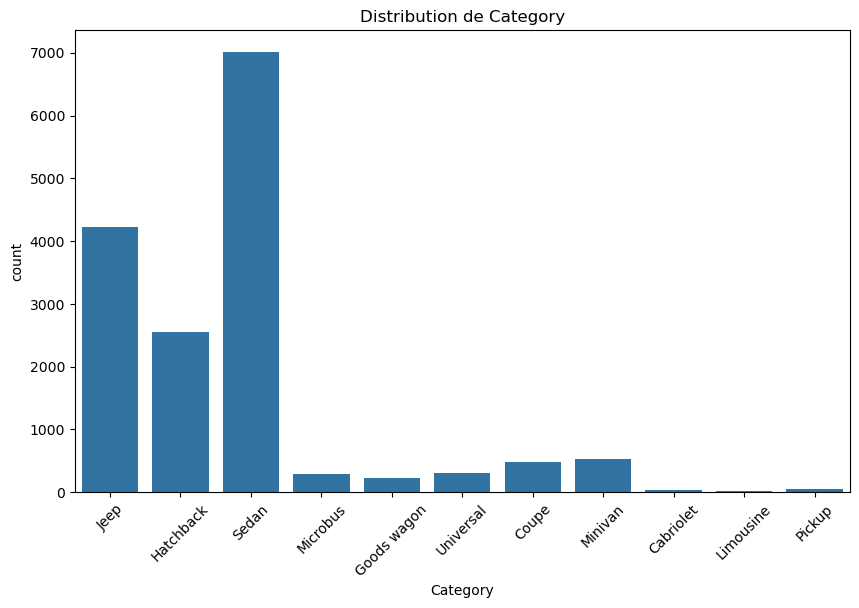

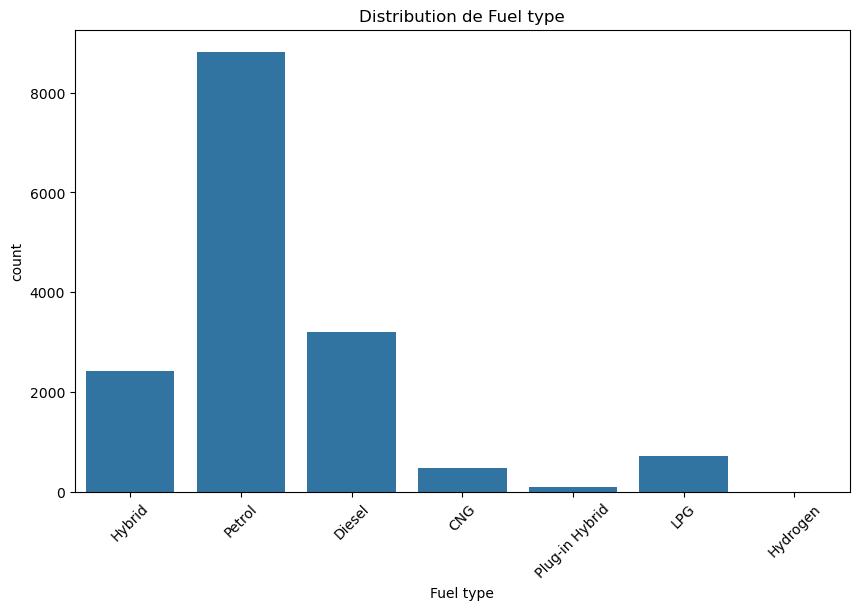

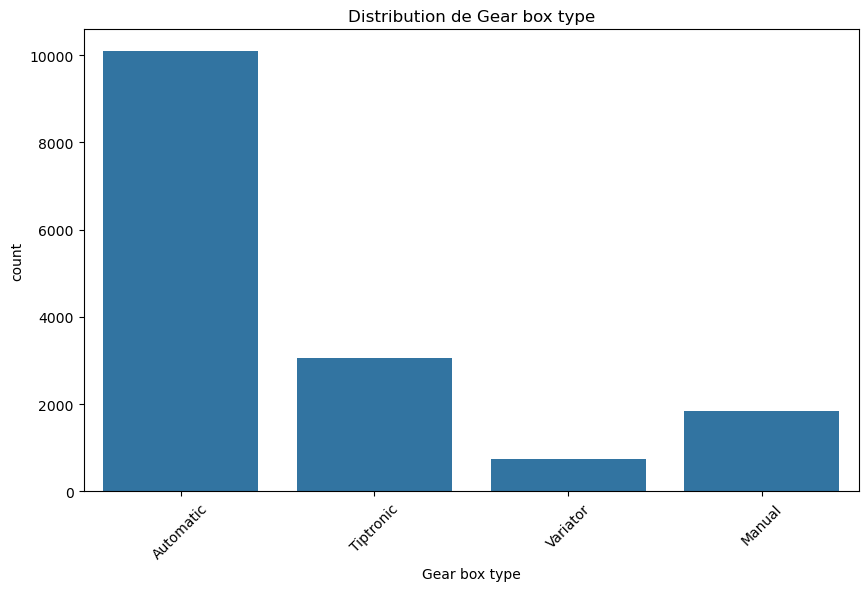

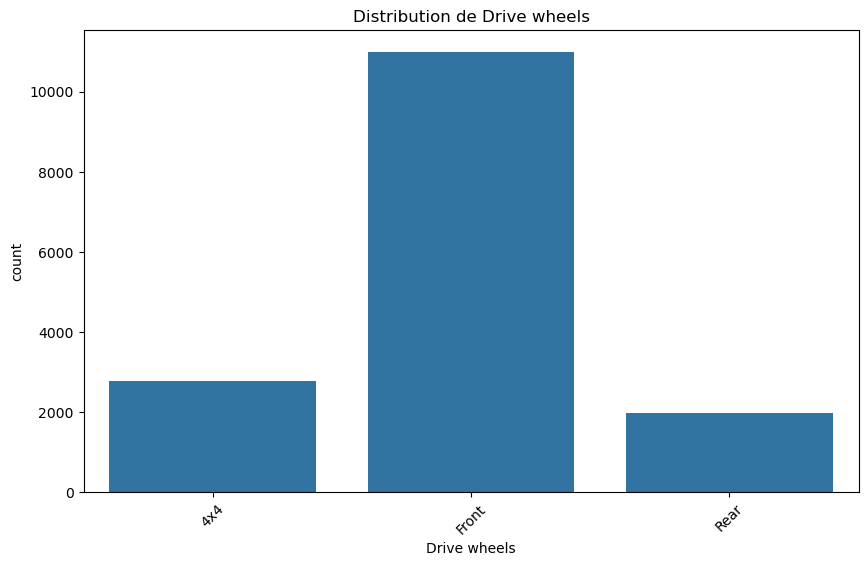

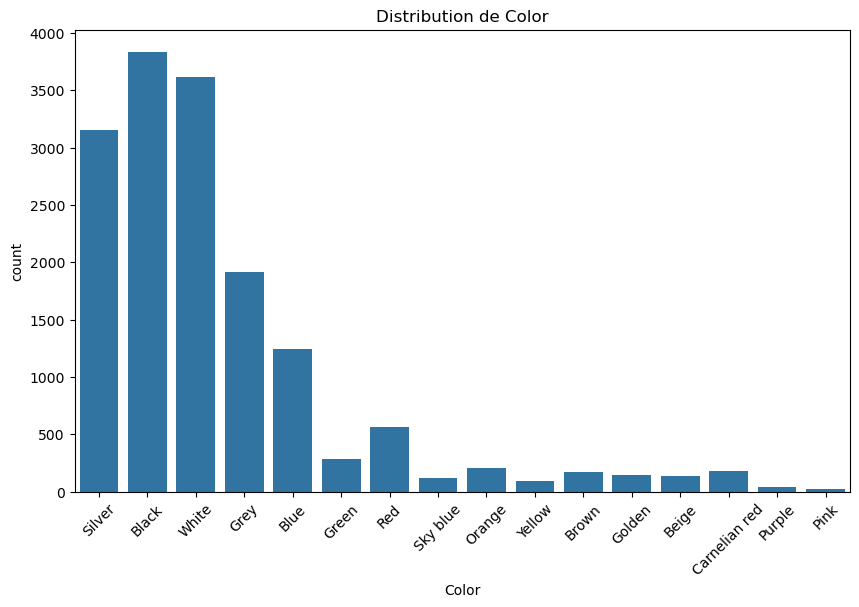

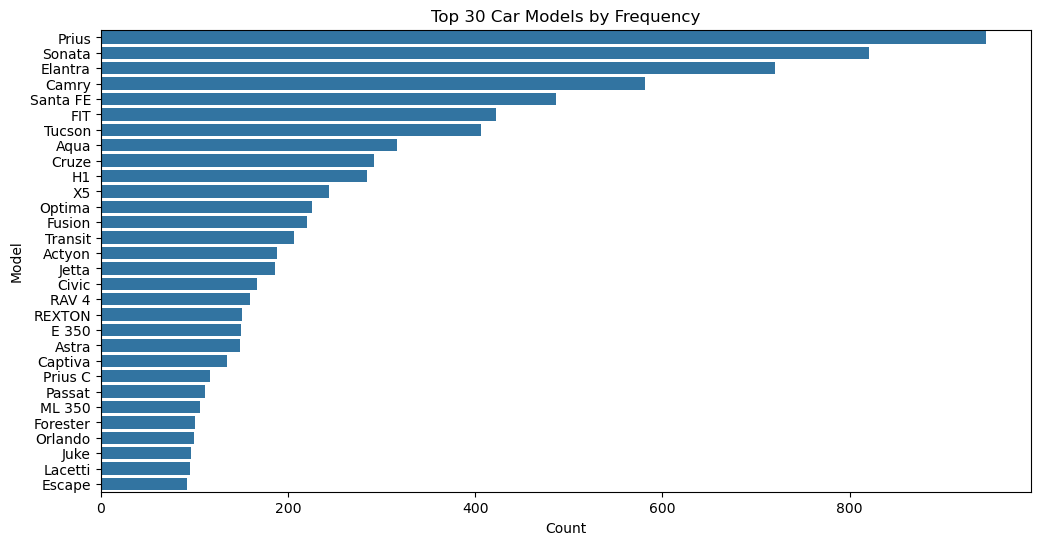

In [35]:
# Afficher les statistiques descriptives
print(dtset.describe())
# Afficher la distribution de la variable 'Price'
plt.figure(figsize=(10, 6))
sns.histplot(dtset['Price'], kde=True, bins=30)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()
# Afficher la corrélation entre les variables (numériques uniquement)
plt.figure(figsize=(12, 8))
numeric_df = dtset.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

# Analyse des variables catégorielles
categorical_cols = dtset.select_dtypes(include=['object']).columns
for col in [c for c in categorical_cols if c != 'Model']:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=dtset, x=col)
    plt.title(f'Distribution de {col}')
    plt.xticks(rotation=45)
    plt.show()

# Afficher un histogramme de la variable 'Model' en se limitant aux 30 modèles les plus fréquents
top_models = dtset['Model'].value_counts().nlargest(30).index
plt.figure(figsize=(12, 6))
sns.countplot(data=dtset[dtset['Model'].isin(top_models)], y='Model', order=top_models)
plt.title('Top 30 Car Models by Frequency')
plt.xlabel('Count')
plt.ylabel('Model')
plt.show()

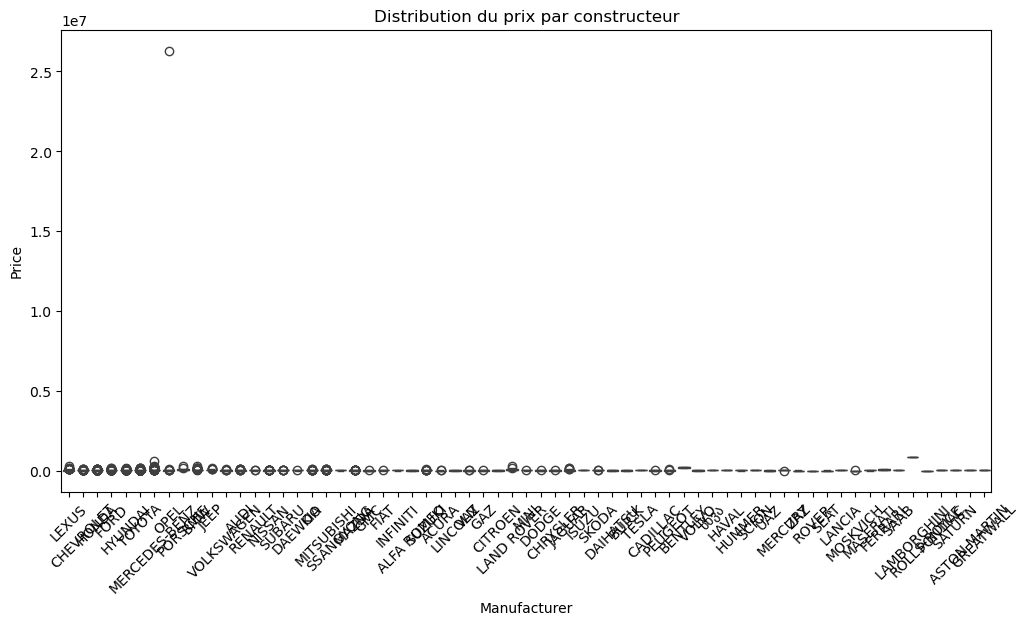

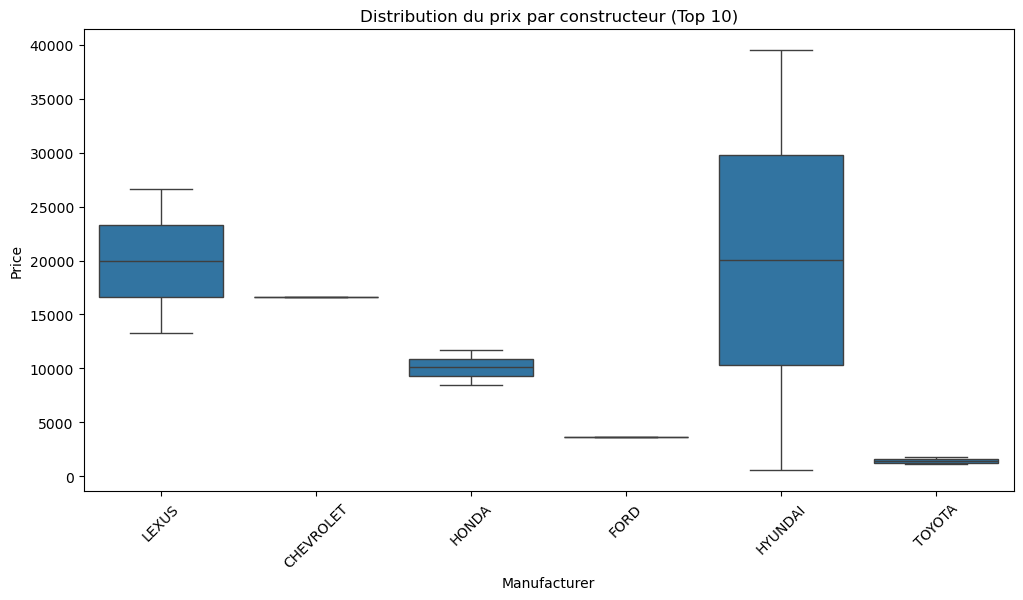

In [36]:
# Boxplot de la variable 'Price' par rapport à 'Manufacturer'
plt.figure(figsize=(12, 6))
sns.boxplot(data=dtset, x='Manufacturer', y='Price')
plt.title('Distribution du prix par constructeur')
plt.xticks(rotation=45)
plt.show()
# Zoom sur les 10 premiers constructeurs
plt.figure(figsize=(12, 6))
sns.boxplot(data=dtset.head(10), x='Manufacturer', y='Price')
plt.title('Distribution du prix par constructeur (Top 10)')
plt.xticks(rotation=45)
plt.show()




In [37]:
# Supprimer la colonne 'Model'
dtset = dtset.drop(['Model'], axis=1)

# Simplification de Manufacturer
top_manufacturers = dtset['Manufacturer'].value_counts()[:10].index
dtset['Manufacturer'] = np.where(dtset['Manufacturer'].isin(top_manufacturers), dtset['Manufacturer'], 'Other')


# afficher les informations du dataset
print(dtset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 15725 entries, 0 to 19236
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             15725 non-null  int64  
 1   Levy              15725 non-null  float64
 2   Manufacturer      15725 non-null  object 
 3   Prod. year        15725 non-null  int64  
 4   Category          15725 non-null  object 
 5   Leather interior  15725 non-null  int64  
 6   Fuel type         15725 non-null  object 
 7   Engine volume     15725 non-null  float64
 8   Mileage           15725 non-null  int64  
 9   Cylinders         15725 non-null  float64
 10  Gear box type     15725 non-null  object 
 11  Drive wheels      15725 non-null  object 
 12  Doors             15725 non-null  int64  
 13  Wheel             15725 non-null  int64  
 14  Color             15725 non-null  object 
 15  Airbags           15725 non-null  int64  
dtypes: float64(3), int64(7), object(6)
memory usa

In [38]:
# Séparation des variables numériques et catégorielles
cat_cols = ['Manufacturer','Category','Fuel type','Gear box type','Drive wheels','Color']
X = pd.get_dummies(dtset.drop('Price',axis=1), columns=cat_cols, drop_first=True)
y = np.log1p(dtset['Price'])

X.head()

,Levy,Prod. year,Leather interior,Engine volume,Mileage,Cylinders,Doors,Wheel,Airbags,Manufacturer_CHEVROLET,...,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow
0,1399.0,2010,1,3.5,186005,6.0,4,0,12,False,...,False,False,False,False,False,False,True,False,False,False
1,1018.0,2011,0,3.0,192000,6.0,4,0,8,True,...,False,False,False,False,False,False,False,False,False,False
2,0.0,2006,0,1.3,200000,4.0,4,1,2,False,...,False,False,False,False,False,False,False,False,False,False
3,862.0,2011,1,2.5,168966,4.0,4,0,0,False,...,False,False,False,False,False,False,False,False,True,False
4,446.0,2014,1,1.3,91901,4.0,4,0,4,False,...,False,False,False,False,False,False,True,False,False,False


In [39]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Normalisation des variables numériques
numeric_cols = ['Levy','Prod. year','Engine volume','Mileage','Cylinders','Doors','Airbags']
scaler = StandardScaler().fit(X_train[numeric_cols])
X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])

In [40]:
lr = LinearRegression()
lr_cv_r2 = cross_val_score(lr, X_train, y_train, cv=5, scoring='r2')
lr_cv_rmse = np.sqrt(-cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
print(f"Linear CV R^2: {lr_cv_r2.mean():.3f} ± {lr_cv_r2.std():.3f}")
print(f"Linear CV RMSE: {lr_cv_rmse.mean():.0f} ± {lr_cv_rmse.std():.0f}")

lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(f"Linear Test R^2: {metrics.r2_score(y_test,y_pred_lr):.3f}")
print(f"Linear Test RMSE: {metrics.mean_squared_error(y_test,y_pred_lr, squared=False):.0f}")

Linear CV R^2: 0.205 ± 0.015
Linear CV RMSE: 1 ± 0
Linear Test R^2: 0.200
Linear Test RMSE: 1


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [41]:
# LassoCV pour trouver alpha
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000).fit(X_train, y_train)
alpha_lasso = lasso_cv.alpha_
lasso = Lasso(alpha=alpha_lasso)
lasso_cv_r2 = cross_val_score(lasso, X_train, y_train, cv=5, scoring='r2')
lasso_cv_rmse = np.sqrt(-cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
print(f"Lasso (α={alpha_lasso:.3f}) CV R^2: {lasso_cv_r2.mean():.3f} ± {lasso_cv_r2.std():.3f}")
print(f"Lasso CV RMSE: {lasso_cv_rmse.mean():.0f} ± {lasso_cv_rmse.std():.0f}")

lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
print(f"Lasso Test R^2: {metrics.r2_score(y_test,y_pred_lasso):.3f}")
print(f"Lasso Test RMSE:{metrics.mean_squared_error(y_test,y_pred_lasso, squared=False):.0f}")

# RidgeCV pour trouver alpha
ridge_cv = RidgeCV(alphas=[0.1,1,10,100], cv=5).fit(X_train, y_train)
alpha_ridge = ridge_cv.alpha_
ridge = Ridge(alpha=alpha_ridge)
ridge_cv_r2 = cross_val_score(ridge, X_train, y_train, cv=5, scoring='r2')
ridge_cv_rmse = np.sqrt(-cross_val_score(ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
print(f"Ridge (α={alpha_ridge:.1f}) CV R^2: {ridge_cv_r2.mean():.3f} ± {ridge_cv_r2.std():.3f}")
print(f"Ridge CV RMSE: {ridge_cv_rmse.mean():.0f} ± {ridge_cv_rmse.std():.0f}")

ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
print(f"Ridge Test R^2: {metrics.r2_score(y_test,y_pred_ridge):.3f}")
print(f"Ridge Test RMSE: {metrics.mean_squared_error(y_test,y_pred_ridge, squared=False):.0f}")

Lasso (α=0.001) CV R^2: 0.206 ± 0.016
Lasso CV RMSE: 1 ± 0
Lasso Test R^2: 0.201
Lasso Test RMSE:1


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Ridge (α=10.0) CV R^2: 0.206 ± 0.015
Ridge CV RMSE: 1 ± 0
Ridge Test R^2: 0.200
Ridge Test RMSE: 1


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


> # On remarque les prédictions avec l'imputation de la '0' dans 'Levy' sont aussi mauvaise que l'imputation de la moyenne dans 'Levy'

> # Cas avec prédiction de la valeur de 'Levy'

In [42]:
# Chargement du dataset
dt = pd.read_csv('/Users/MAC/Downloads/car_price_prediction.csv')

In [43]:
# Conversion de 'Levy' en numérique (remplace '-' par NaN)
dt['Levy'] = pd.to_numeric(dt['Levy'], errors='coerce')

# Extraire la partie numérique de 'Mileage' et convertir en float
dt['Mileage'] = dt['Mileage'].str.extract(r'(\d+)').astype(float) 

# Nettoyer la colonne 'Doors'
dt['Doors'] = dt['Doors'].replace({'04-May': '4-5', '02-Mar': '2-3', '>5': '6+'})

# Extraire la valeur numérique de 'Engine volume' et créer 'Turbo'
dt['Turbo'] = dt['Engine volume'].str.contains('Turbo').astype(int)
dt['Engine volume'] = dt['Engine volume'].str.extract(r'(\d+\.\d+|\d+)').astype(float) 

# Calculer l'âge du véhicule
dt['Age'] = 2025 - dt['Prod. year']

# Supprimer les colonnes inutiles
dt = dt.drop(['ID', 'Wheel'], axis=1)
duplicates = dt[dt.duplicated(keep=False)]  

# Afficher les lignes dupliquées
if duplicates.empty:
    print("No duplicate rows found.")
else:
    print(f"Found {len(duplicates)} duplicate rows:")
    print(duplicates.sort_values(by=duplicates.columns.tolist()).head())

# Compter les doublons et afficher le nombre de fois que chaque doublon apparaît
duplicate_counts = duplicates.groupby(dt.columns.tolist()).size().reset_index(name='Count')
print("\nDuplicate counts:")
print(duplicate_counts)

# Supprimer les doublons
dt.drop_duplicates(inplace=True)
dt.head(100)

Found 4927 duplicate rows:
      Price  Levy Manufacturer Model  Prod. year   Category Leather interior  \
214      30   NaN        HONDA   FIT        2002  Hatchback               No   
7466     30   NaN        HONDA   FIT        2002  Hatchback               No   
2285     30   NaN        HONDA   FIT        2003  Hatchback               No   
2747     30   NaN        HONDA   FIT        2003  Hatchback               No   
6813     30   NaN        HONDA   FIT        2003  Hatchback               No   

     Fuel type  Engine volume  Mileage  Cylinders Gear box type Drive wheels  \
214     Petrol            1.5      0.0        4.0     Automatic        Front   
7466    Petrol            1.5      0.0        4.0     Automatic        Front   
2285    Petrol            1.3      0.0        4.0     Automatic        Front   
2747    Petrol            1.3      0.0        4.0     Automatic        Front   
6813    Petrol            1.3      0.0        4.0     Automatic        Front   

     Doors 

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Color,Airbags,Turbo,Age
0,13328,1399.0,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005.0,6.0,Automatic,4x4,4-5,Silver,12,0,15
1,16621,1018.0,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000.0,6.0,Tiptronic,4x4,4-5,Black,8,0,14
2,8467,NaN,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000.0,4.0,Variator,Front,4-5,Black,2,0,19
3,3607,862.0,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966.0,4.0,Automatic,4x4,4-5,White,0,0,14
4,11726,446.0,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901.0,4.0,Automatic,Front,4-5,Silver,4,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,32929,NaN,BMW,428 Sport Line,2013,Coupe,Yes,Petrol,2.0,160000.0,4.0,Automatic,Rear,2-3,Black,12,1,12
96,18817,NaN,NISSAN,Patrol,1990,Jeep,No,Diesel,2.8,333333.0,4.0,Manual,Rear,4-5,Black,0,1,35
97,4234,NaN,HONDA,Civic,1997,Hatchback,Yes,Petrol,1.4,0.0,4.0,Manual,Front,2-3,Blue,6,0,28
98,15053,NaN,MERCEDES-BENZ,E 320,2004,Sedan,Yes,Petrol,3.2,214000.0,6.0,Tiptronic,Rear,4-5,Grey,8,0,21


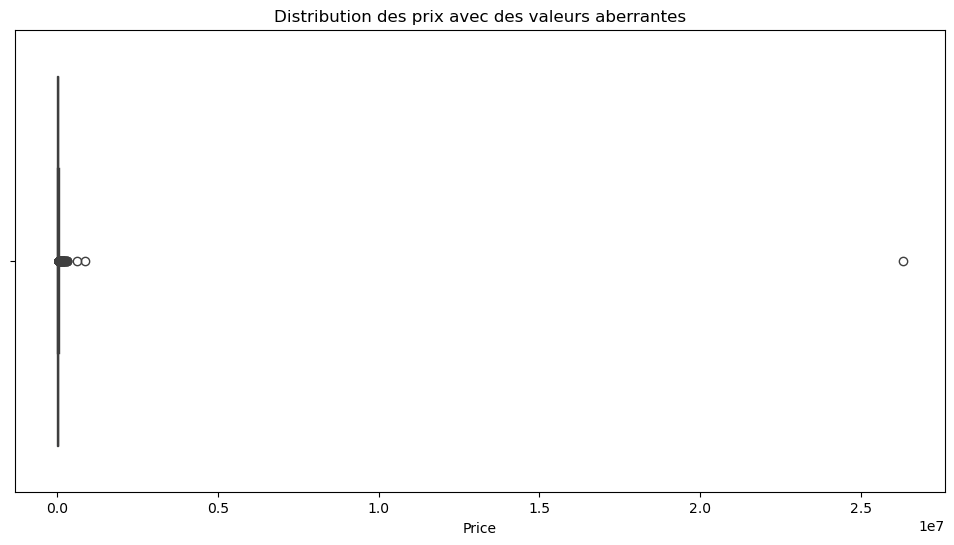

Pourcentage de valeurs aberrantes : 6.09%


In [44]:
# Grapher la distribution des prix
plt.figure(figsize=(12,6))
sns.boxplot(x=dt['Price'])
plt.title('Distribution des prix avec des valeurs aberrantes')
plt.show()

# Methode pour identifier les valeurs aberrantes
# Utiliser l'IQR pour identifier les valeurs aberrantes
Q1 = dt['Price'].quantile(0.25)
Q3 = dt['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Marquer les valeurs aberrantes sans supprimer
dt['Outlier'] = ((dt['Price'] < lower_bound) | (dt['Price'] > upper_bound)).astype(int)
print(f"Pourcentage de valeurs aberrantes : {dt['Outlier'].mean()*100:.2f}%")

# Traitement spécial pour les voitures de luxe
luxury_manufacturers = ['Rolls-Royce', 'Ferrari', 'Lamborghini', 'Bugatti', 
                        'Bentley', 'Aston Martin', 'Maserati', 'Porsche', 
                        'Mercedes-Benz', 'Jaguar', 'Maybach', 'Lexus']
dt['Luxury'] = dt['Manufacturer'].isin(luxury_manufacturers).astype(int)

> * Identifie les valeurs extrêmes tout en préservant les véhicules de luxe
> * Utilise la méthode IQR pour les valeurs aberrantes définies statistiquement
> * Signale plutôt que supprime pour conserver les informations précieuses

> # Critères de classification des voitures de luxe
>> * Seuils des classes de prix (basés sur les normes de l'industrie) :
>>> * Voitures économiques : Prix < 15 000 $
>>> * Voitures de milieu de gamme : 15 000 $ ≤ Prix < 50 000 $
>>> * Voitures de luxe : Prix ≥ 50 000 $
>>
>> * Indicateurs de luxe supplémentaires :
>>> * Constructeur dans la liste des marques de luxe
>>> * Âge ≤ 5 ans avec un 'Mileage' ≤ 30 000 km
>>> * Airbags ≥ 8 et Intérieur cuir = "yes".

Price_Class
Economy      0.518029
Mid-Range    0.429571
Luxury       0.052401
Name: proportion, dtype: float64


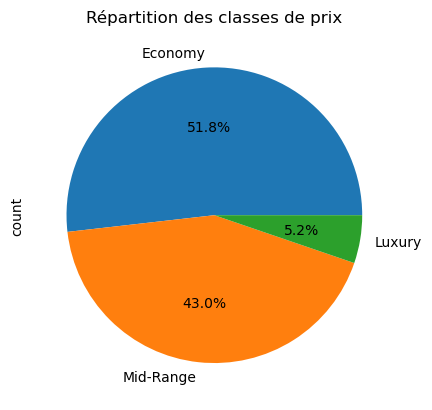

In [45]:
# Créer une nouvelle colonne 'Price_Class' pour classer les voitures
# en 'Economy', 'Mid-Range', et 'Luxury'
bins = [0, 15000, 50000, float('inf')]
labels = ['Economy', 'Mid-Range', 'Luxury']
dt['Price_Class'] = pd.cut(dt['Price'], bins=bins, labels=labels)

# Vérifier la distribution des classes de prix


print(dt['Price_Class'].value_counts(normalize=True))

# Visualiser la répartition des classes de prix


dt['Price_Class'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Répartition des classes de prix')
plt.show()

> * Large base économique (51.8%)
> * Segment intermédiaire important (43.0%)
> * Sommet de luxe très étroit (5.2%)
> Ce qui correspond à la structure typique des marchés automobiles grand public
> Les seuils choisis (15k$ et 50k$) semblent pertinents car :
>> 1. Ils créent des catégories bien différenciées
>> 2. La distribution correspond aux attentes du marché automobile
>> 3. Le segment moyen est significatif sans être dominant

> # Imputation les valeurs manquantes de 'Levy'

In [46]:
# 1. Créer la colonne cible avant l'imputation
dt['Levy_imputed'] = dt['Levy']

# 2. Sélectionner les caractéristiques SANS exclure Levy_imputed
levy_features = dt.drop(['Price', 'Price_Class'], axis=1)

# 3. Mise à jour des caractéristiques catégorielles et numériques
numeric_features = ['Age', 'Mileage',  'Cylinders', 'Airbags', 'Engine volume', 'Turbo']
categorical_features = ['Manufacturer', 'Category', 'Leather interior', 'Model',
                        'Fuel type', 'Gear box type', 'Drive wheels', 'Color', 'Doors']

# 4. Préprocesseur avec sortie dense
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# 5. Pipeline avec conversion de dimension
levy_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', KNNImputer(n_neighbors=5))
])

# 6. Appliquer l'imputation et récupérer uniquement la colonne Levy
imputed_data = levy_pipeline.fit_transform(levy_features)
levy_col_index = levy_features.columns.get_loc('Levy_imputed')  # Index de la colonne Levy
dt['Levy_imputed'] = imputed_data[:, levy_col_index]  # Extraire uniquement cette colonne

> * Utilise l'imputation KNN pour préserver les relations entre les caractéristiques
> * Exclut le prix pour éviter les fuites de cibles
> * Maintient l'intégrité de l'ensemble de données pour les prédictions de prix ultérieures

> # Mise en oeuvre des caractéristiques pour le modèle principal

In [47]:
# Créer de nouvelles caractéristiques basées sur les données existantes
dt['Mileage_to_Age'] = dt['Mileage'] / (dt['Age'] + 1)  # +1 pour éviter la division par zéro
dt['Engine_to_Cylinders'] = dt['Engine volume'] / (dt['Cylinders'] + 0.1)

# Sélectionner les caractéristiques pour l'entraînement du modèle
features = ['Levy_imputed', 'Manufacturer', 'Model','Category', 'Leather interior',
            'Fuel type', 'Engine volume', 'Mileage', 'Cylinders', 'Gear box type',
            'Drive wheels', 'Doors', 'Color', 'Airbags', 'Age', 'Turbo', 
            'Mileage_to_Age', 'Engine_to_Cylinders']

> # Construction des modèles

> ## Modèle de Régression

In [48]:
# Split des données pour la régression
X = dt[features]
y_reg = dt['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# pipeline de régression
reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Entraîner le modèle de régression et faire des prédictions
reg_pipeline.fit(X_train, y_train)
y_pred_reg = reg_pipeline.predict(X_test)

# Evaluer les performances du modèle de régression
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_reg))
r2 = metrics.r2_score(y_test, y_pred_reg)
print(f"Regression Metrics:\nRMSE: {rmse:.2f}\nR²: {r2:.4f}")

Regression Metrics:
RMSE: 9962.59
R²: 0.6891


> * RMSE: 9962.59
>> En moyenne, les prédictions de prix du modèle s'écartent de ±9962.59$ du prix réel
>> Pour une voiture valant 20 000$, la prédiction serait typiquement entre 10 686$ et 29962$
>
> R²:  0.6891
>> Le modèle explique 68.91% de la variance des prix


> # Amelioration des modèles de régression

In [49]:
# Paramètres à tester
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5]
}

# Grid Search simple
grid_search = GridSearchCV(reg_pipeline, param_grid, cv=3, scoring='r2')
grid_search.fit(X_train, y_train)

# Meilleur modèle
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

KeyboardInterrupt: 

In [ ]:

# Remplacer le régresseur
reg_pipeline.set_params(regressor=XGBRegressor(n_estimators=200, random_state=42))

# Entraînement rapide
reg_pipeline.fit(X_train, y_train)

In [ ]:

# Transformation log
y_train_log = np.log1p(y_train)
reg_pipeline.fit(X_train, y_train_log)

# Prédiction + transformation inverse
y_pred = np.expm1(reg_pipeline.predict(X_test))

In [ ]:


# Modifier le pipeline
reg_pipeline.steps.insert(1, ('poly', PolynomialFeatures(degree=2, include_bias=False)))
reg_pipeline.fit(X_train, y_train)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

reg_pipeline.steps.insert(1, ('poly', PolynomialFeatures(degree=2, include_bias=False)))

In [ ]:
# Cap des valeurs extrêmes
X_train['feature_name'] = np.where(X_train['feature_name'] > X_train['feature_name'].quantile(0.95),
                                   X_train['feature_name'].quantile(0.95),
                                   X_train['feature_name'])

In [ ]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2 = metrics.r2_score(y_test, y_pred)
print(f"Improved Metrics:\nRMSE: {rmse:.2f}\nR²: {r2:.4f}")

> ## Modèle de classification (Donner des classes de Prix)

In [ ]:


y_clf = dt['Price_Class']

# Split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

# Pipeline de classification
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Entraîner le modèle de classification et faire des prédictions
clf_pipeline.fit(X_train_clf, y_train_clf)
y_pred_clf = clf_pipeline.predict(X_test_clf)

# Evaluation des performances du modèle de classification
accuracy = metrics.accuracy_score(y_test_clf, y_pred_clf)
f1 = metrics.f1_score(y_test_clf, y_pred_clf, average='weighted')
print(f"Classification Metrics:\nAccuracy: {accuracy:.4f}\nF1-Score: {f1:.4f}")

#

Classification Metrics:
Accuracy: 0.8099
F1-Score: 0.8071


> * Accuracy (Exactitude) = 0.8099(80.99%)
>> Le modèle prédit correctement la catégorie de prix pour 86.23% des véhicules, Sur 100 véhicules, le modèle classe correctement 81 dans leur catégorie de prix réelle (Economy, Mid-Range ou Luxury)
>
> * F1-Score (moyenne pondérée) =0.8071  (80.71%)
>> Indique un bon équilibre entre précision (exactitude des prédictions positives) et rappel (capacité à trouver tous les positifs)
Le score est très proche de l'accuracy (80.99% vs 80.71%), ce qui suggère une performance homogène entre les classes
>
> ### Performance globale Assez bonne :
>> * Un score >80% est considéré comme bon pour un problème de classification multiclasse
Le modèle distingue efficacement les trois segments de prix
>> * Rappel de la distribution : Economy (51.8%), Mid-Range (43.0%), Luxury (5.2%), La performance homogène (F1 proche de l'accuracy) indique que le modèle gère bien le déséquilibre des classes
>> * La classe minoritaire (Luxury) est probablement bien identifiée malgré sa petite taille
>
> # Comparaison avec le modèle de régression
>> * La classification (81% de précision) surpasse la régression (R²=68%) en performance relative, Cela suggère qu'il est plus facile de prédire la catégorie de prix que le prix exact

In [ ]:
# Importance des caractéristiques pour la régression
reg_model = reg_pipeline.named_steps['regressor']
importances = reg_model.feature_importances_

# Récupérer les noms des caractéristiques
ohe_columns = list(preprocessor.named_transformers_['cat'].get_feature_names_out(input_features=categorical_features))
all_features = numeric_features + ohe_columns


# Sauvegarder les modèles
import joblib
joblib.dump(reg_pipeline, 'car_price_regressor.pkl')
joblib.dump(clf_pipeline, 'price_class_classifier.pkl')

['price_class_classifier.pkl']